## Single-cell RNA Seq Data Processing and Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
from matplotlib import cm, colors
import scipy.cluster.hierarchy as sch
import seaborn as sns
import datetime
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import anndata

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)
sc.settings.figdir = './datasets/mammary_gland/figures'

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.7.1


#### Keeping Cells Used in the Paper

In [3]:
file = './datasets/mammary_gland/data/clust_anno.csv'

df = pd.read_csv(file, usecols = ['barcode', 'Condition', 'PassAll', 'Cluster', 'SubCluster', 'SuperCluster'])

df.head()
 
new_bc = []

for i in df['barcode']:
    new_bc.append(i[:-2])
    
df['barcode'] = new_bc

In [4]:
df

barcode Condition  PassAll  Cluster SubCluster SuperCluster
0      AAACCTGAGGAATTAC        PI     True      4.0      Lp-PI           Lp
1      AAACCTGTCTCTTATG        PI     True      4.0      Lp-PI           Lp
2      AAACGGGAGCCCAACC        PI     True      3.0     Hsp-PI          Hsp
3      AAACGGGAGTGACATA        PI     True      4.0      Lp-PI           Lp
4      AAACGGGGTCTGCAAT        PI     True      4.0      Lp-PI           Lp
...                 ...       ...      ...      ...        ...          ...
25801  TTTGGTTTCGTACGGC        NP     True      5.0     Hsd-NP          Hsd
25802  TTTGTCACACCTCGGA        NP     True      3.0     Hsp-NP          Hsp
25803  TTTGTCACACGACGAA        NP     True      5.0     Hsd-NP          Hsd
25804  TTTGTCAGTTGAGTTC        NP     True      1.0      Lp-NP           Lp
25805  TTTGTCAGTTGTACAC        NP     True      3.0     Hsp-NP          Hsp

[25806 rows x 6 columns]

### Nulliparous Pre-Processing

In [5]:
results_file = './datasets/mammary_gland/results/all_data.h5ad'  # the file that will store the analysis results

np_files = ['./datasets/mammary_gland/data/np_1/', './datasets/mammary_gland/data/np_2/']
np_adatas = [sc.read_10x_mtx(
    filename,  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading
    for filename in np_files]
np_adata = np_adatas[0].concatenate(np_adatas[1:])
np_df = np_adata.to_df()
obs = np_adata.obs
var = np_adata.var['gene_ids']

to_remove = []
for i in np_adata.obs.index:
    i = i[:-4]
    row = df.loc[df['barcode'] == i]
    if row['PassAll'].iloc[0] == False:
        to_remove.append(i)
        
np_df = np_df.drop(np_df[np_df.index.str.contains('|'.join(to_remove))].index, axis=0)
obs = obs.drop(obs[obs.index.str.contains('|'.join(to_remove))].index, axis=0)

np_adata = anndata.AnnData(X = np_df, obs = obs, var= var)
np_label = ['np']*len(np_adata.obs.index)
np_adata.obs['tissue'] = np_label
np_adata

... reading from cache file cache/datasets-mammary_gland-data-np_1-matrix.h5ad
... reading from cache file cache/datasets-mammary_gland-data-np_2-matrix.h5ad


AnnData object with n_obs × n_vars = 4223 × 27998 
    obs: 'batch', 'tissue'
    var: 'gene_ids'

Nulliparous Mammary Gland Epithelial Cells Pre-Processing
normalizing counts per cell
    finished (0:00:00)


... storing 'tissue' as categorical
... storing 'gene_ids' as categorical


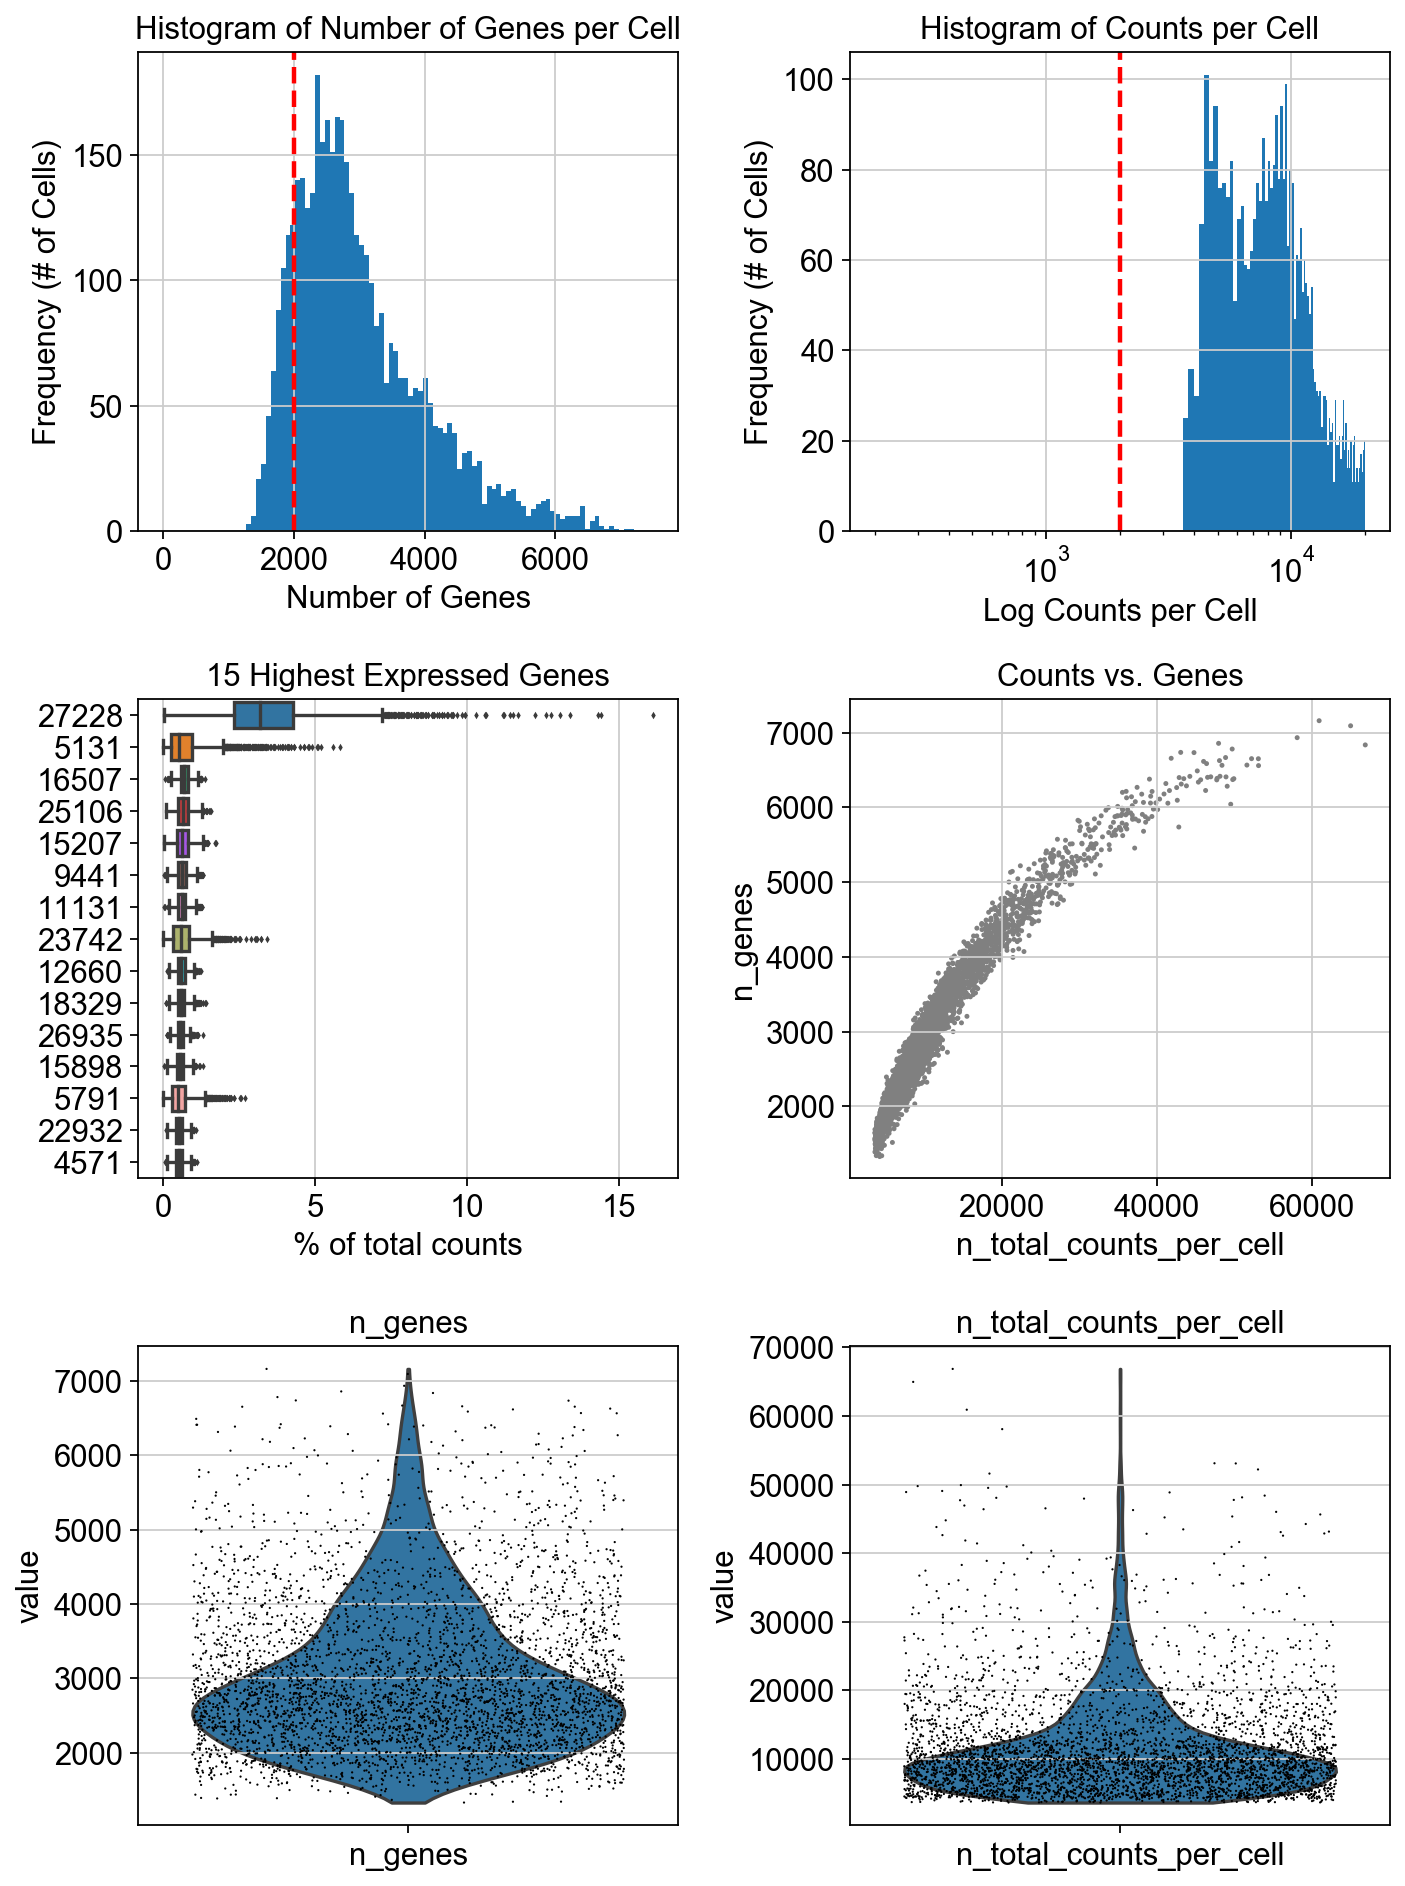

In [6]:
print('Nulliparous Mammary Gland Epithelial Cells Pre-Processing')
sc.pp.filter_cells(np_adata, min_genes=0)
sc.pp.filter_genes(np_adata, min_cells=0)

X = np.matrix(np_adata.X)

# Total counts, cells per gene, and mitochondrial genes
np_adata.obs['n_total_counts_per_cell'] = X.sum(axis=1).A1
np_adata.var['n_cells_per_gene'] = X.astype(bool).astype(int).sum(axis=0).A1
np_adata.obs['n_genes_per_cell'] = X.astype(bool).astype(int).sum(axis=1).A1

fig, ax = plt.subplots(3, 2, figsize = (9, 12))

ax[0,0].hist(np_adata.obs['n_genes_per_cell'][:], bins = 100, range = (0, 7500))
ax[0,0].set_title('Histogram of Number of Genes per Cell')
ax[0,0].set_xlabel('Number of Genes')
ax[0,0].set_ylabel('Frequency (# of Cells)')
ax[0,0].axvline(x=2000, color='r', linestyle='dashed', linewidth=2)

ax[0,1].hist(np_adata.obs['n_total_counts_per_cell'][:], 
             bins = 100, range = (0, 20000))
ax[0,1].set_title('Histogram of Counts per Cell')
ax[0,1].set_xlabel('Log Counts per Cell')
ax[0,1].set_ylabel('Frequency (# of Cells)')
ax[0,1].set_xscale('log')
ax[0,1].axvline(x=2000, color='r', linestyle='dashed', linewidth=2)

sc.pl.highest_expr_genes(np_adata, n_top=15, ax=ax[1,0], show=False)
ax[1,0].set_title('15 Highest Expressed Genes')
sc.pl.scatter(np_adata, x='n_total_counts_per_cell', y='n_genes', size = 20, 
              title = 'Counts vs. Genes', ax=ax[1,1], show=False)

sc.pl.violin(np_adata, keys='n_genes', jitter=0.4, show = False, ax=ax[2,0])
ax[2,0].set_title('n_genes')
sc.pl.violin(np_adata, keys='n_total_counts_per_cell', jitter=0.4, show = False, ax=ax[2,1])
ax[2,1].set_title('n_total_counts_per_cell')
fig.tight_layout()

In [7]:
sc.pp.filter_cells(np_adata, min_genes = 1042)

### Lactation Pre-Processing

In [8]:
l_files = ['./datasets/mammary_gland/data/l_1/', './datasets/mammary_gland/data/l_2/']
l_adatas = [sc.read_10x_mtx(
    filename,  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading
    for filename in l_files]
l_adata = l_adatas[0].concatenate(l_adatas[1:])
l_adata.obs['batch'].replace(['0', '1'], ['2', '3'], inplace = True)

l_df = l_adata.to_df()
obs = l_adata.obs
var = l_adata.var['gene_ids']

to_remove = []
for i in l_adata.obs.index:
    i = i[:-4]
    row = df.loc[df['barcode'] == i]
    if row['PassAll'].iloc[0] == False:
        to_remove.append(i)
        
l_df = l_df.drop(l_df[l_df.index.str.contains('|'.join(to_remove))].index, axis=0)
obs = obs.drop(obs[obs.index.str.contains('|'.join(to_remove))].index, axis=0)

l_adata = anndata.AnnData(X = l_df, obs = obs, var= var)
l_label = ['l']*len(l_adata.obs.index)
l_adata.obs['tissue'] = l_label
l_adata

... reading from cache file cache/datasets-mammary_gland-data-l_1-matrix.h5ad
... reading from cache file cache/datasets-mammary_gland-data-l_2-matrix.h5ad


AnnData object with n_obs × n_vars = 9319 × 27998 
    obs: 'batch', 'tissue'
    var: 'gene_ids'

Lactation Mammary Gland Epithelial Cells Pre-Processing
normalizing counts per cell
    finished (0:00:01)


... storing 'batch' as categorical
... storing 'tissue' as categorical
... storing 'gene_ids' as categorical


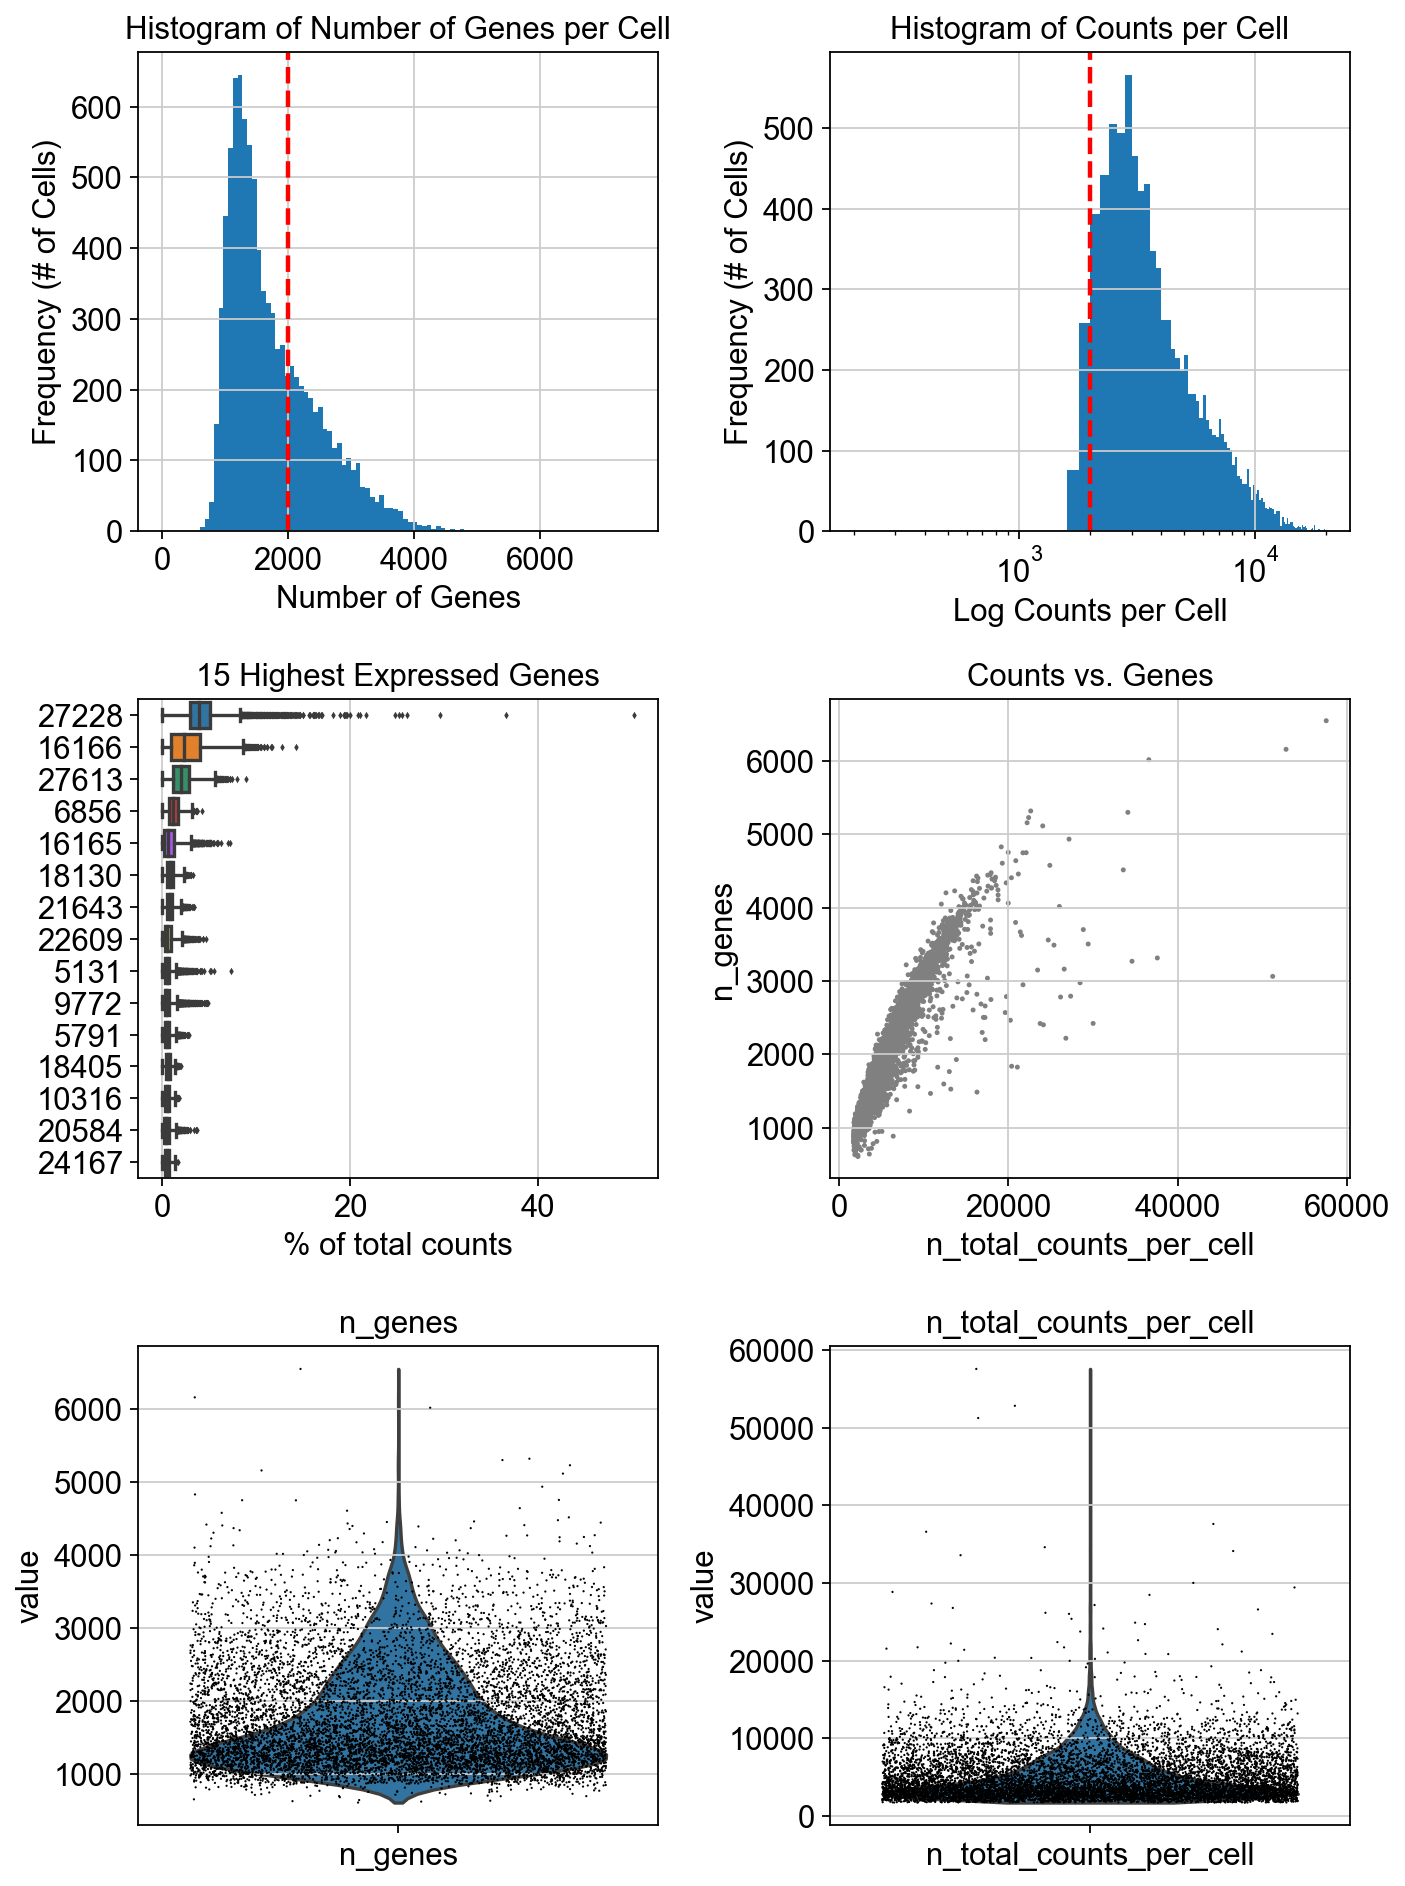

In [9]:
print('Lactation Mammary Gland Epithelial Cells Pre-Processing')
sc.pp.filter_cells(l_adata, min_genes=0)
sc.pp.filter_genes(l_adata, min_cells=0)

X = np.matrix(l_adata.X)

# Total counts, cells per gene, and mitochondrial genes
l_adata.obs['n_total_counts_per_cell'] = X.sum(axis=1).A1
l_adata.var['n_cells_per_gene'] = X.astype(bool).astype(int).sum(axis=0).A1
l_adata.obs['n_genes_per_cell'] = X.astype(bool).astype(int).sum(axis=1).A1

fig, ax = plt.subplots(3, 2, figsize = (9, 12))

ax[0,0].hist(l_adata.obs['n_genes_per_cell'][:], bins = 100, range = (0, 7500))
ax[0,0].set_title('Histogram of Number of Genes per Cell')
ax[0,0].set_xlabel('Number of Genes')
ax[0,0].set_ylabel('Frequency (# of Cells)')
ax[0,0].axvline(x=2000, color='r', linestyle='dashed', linewidth=2)

ax[0,1].hist(l_adata.obs['n_total_counts_per_cell'][:], 
             bins = 100, range = (0, 20000))
ax[0,1].set_title('Histogram of Counts per Cell')
ax[0,1].set_xlabel('Log Counts per Cell')
ax[0,1].set_ylabel('Frequency (# of Cells)')
ax[0,1].set_xscale('log')
ax[0,1].axvline(x=2000, color='r', linestyle='dashed', linewidth=2)


sc.pl.highest_expr_genes(l_adata, n_top=15, ax=ax[1,0], show=False)
ax[1,0].set_title('15 Highest Expressed Genes')
sc.pl.scatter(l_adata, x='n_total_counts_per_cell', y='n_genes', size = 20, 
              title = 'Counts vs. Genes', ax=ax[1,1], show=False)

sc.pl.violin(l_adata, keys='n_genes', jitter=0.4, show = False, ax=ax[2,0])
ax[2,0].set_title('n_genes')
sc.pl.violin(l_adata, keys='n_total_counts_per_cell', jitter=0.4, show = False, ax=ax[2,1])
ax[2,1].set_title('n_total_counts_per_cell')
fig.tight_layout()

In [10]:
sc.pp.filter_cells(l_adata, min_genes = 500)

### Gestation Pre-Processing

In [11]:
g_files = ['./datasets/mammary_gland/data/g_1/', './datasets/mammary_gland/data/g_2/']
g_adatas = [sc.read_10x_mtx(
    filename,  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading
    for filename in g_files]
g_adata = g_adatas[0].concatenate(g_adatas[1:])

g_adata.obs['batch'].replace(['0', '1'], ['4', '5'], inplace = True)

g_df = g_adata.to_df()
obs = g_adata.obs
var = g_adata.var['gene_ids']

to_remove = []
for i in g_adata.obs.index:
    i = i[:-4]
    row = df.loc[df['barcode'] == i]
    if row['PassAll'].iloc[0] == False:
        to_remove.append(i)
        
g_df = g_df.drop(g_df[g_df.index.str.contains('|'.join(to_remove))].index, axis=0)
obs = obs.drop(obs[obs.index.str.contains('|'.join(to_remove))].index, axis=0)

g_adata = anndata.AnnData(X = g_df, obs = obs, var= var)
g_label = ['g']*len(g_adata.obs.index)
g_adata.obs['tissue'] = g_label
g_adata

... reading from cache file cache/datasets-mammary_gland-data-g_1-matrix.h5ad
... reading from cache file cache/datasets-mammary_gland-data-g_2-matrix.h5ad


AnnData object with n_obs × n_vars = 5826 × 27998 
    obs: 'batch', 'tissue'
    var: 'gene_ids'

Gestation Mammary Gland Epithelial Cells Pre-Processing
normalizing counts per cell
    finished (0:00:00)


... storing 'batch' as categorical
... storing 'tissue' as categorical
... storing 'gene_ids' as categorical


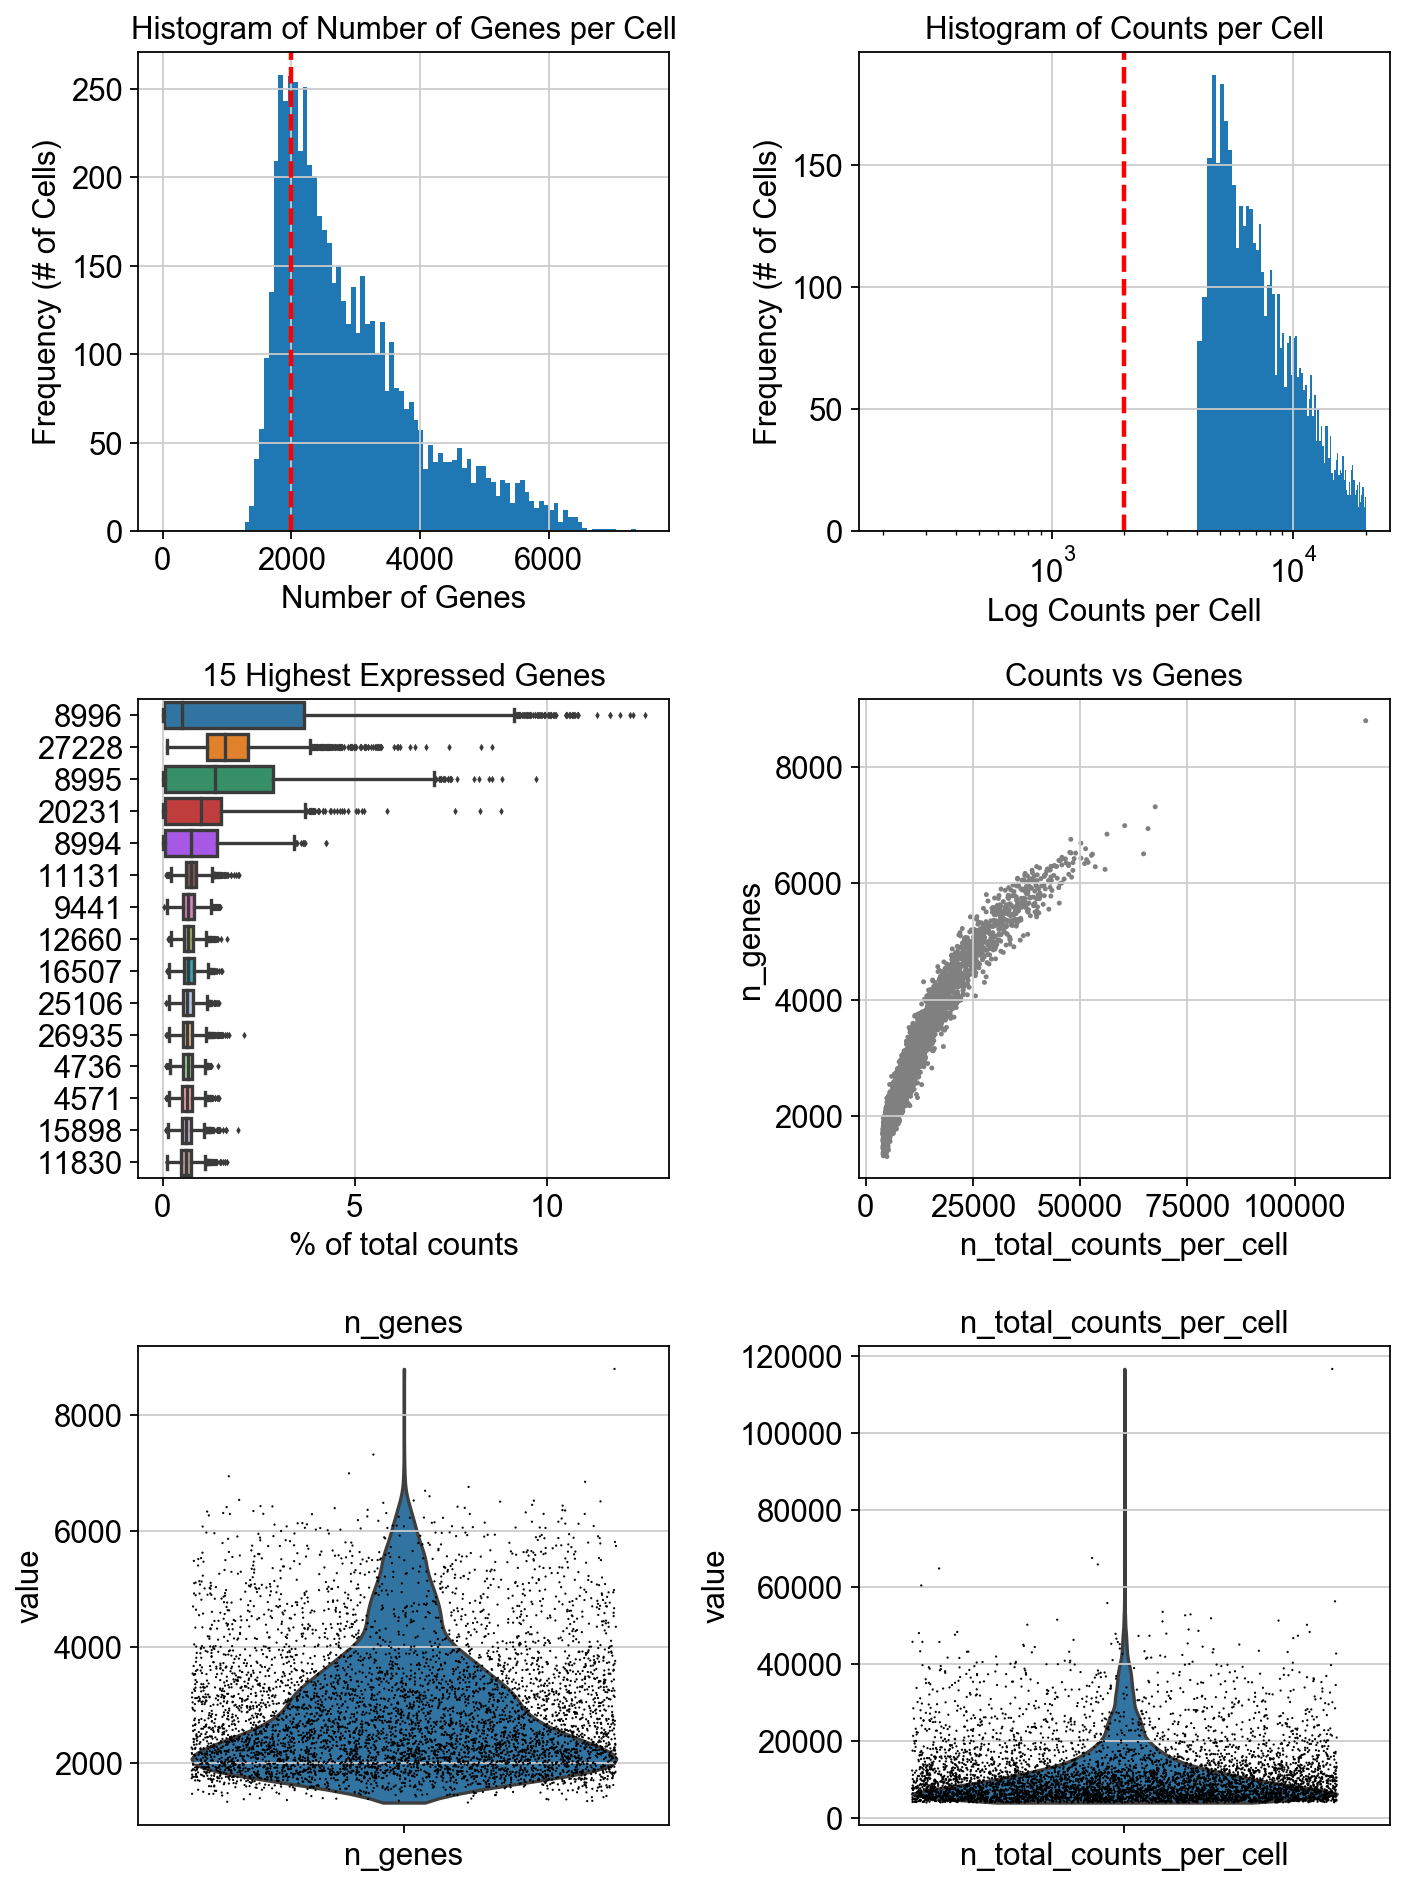

In [12]:
print('Gestation Mammary Gland Epithelial Cells Pre-Processing')
sc.pp.filter_cells(g_adata, min_genes=0)
sc.pp.filter_genes(g_adata, min_cells=0)

X = np.matrix(g_adata.X)


# Total counts, cells per gene, and mitochondrial genes
g_adata.obs['n_total_counts_per_cell'] = X.sum(axis=1).A1
g_adata.var['n_cells_per_gene'] = X.astype(bool).astype(int).sum(axis=0).A1
g_adata.obs['n_genes_per_cell'] = X.astype(bool).astype(int).sum(axis=1).A1

fig, ax = plt.subplots(3, 2, figsize = (9, 12))

ax[0,0].hist(g_adata.obs['n_genes_per_cell'][:], bins = 100, range = (0, 7500))
ax[0,0].set_title('Histogram of Number of Genes per Cell')
ax[0,0].set_xlabel('Number of Genes')
ax[0,0].set_ylabel('Frequency (# of Cells)')
ax[0,0].axvline(x=2000, color='r', linestyle='dashed', linewidth=2)

ax[0,1].hist(g_adata.obs['n_total_counts_per_cell'][:], 
             bins = 100, range = (0, 20000))
ax[0,1].set_title('Histogram of Counts per Cell')
ax[0,1].set_xlabel('Log Counts per Cell')
ax[0,1].set_ylabel('Frequency (# of Cells)')
ax[0,1].set_xscale('log')
ax[0,1].axvline(x=2000, color='r', linestyle='dashed', linewidth=2)


sc.pl.highest_expr_genes(g_adata, n_top=15, ax=ax[1,0], show=False)
ax[1,0].set_title('15 Highest Expressed Genes')
sc.pl.scatter(g_adata, x='n_total_counts_per_cell', y='n_genes', size = 20, 
              title = 'Counts vs Genes', ax=ax[1,1], show=False)

sc.pl.violin(g_adata, keys='n_genes', jitter=0.4, show = False, ax=ax[2,0])
ax[2,0].set_title('n_genes')
sc.pl.violin(g_adata, keys='n_total_counts_per_cell', jitter=0.4, show = False, ax=ax[2,1])
ax[2,1].set_title('n_total_counts_per_cell')
fig.tight_layout()

In [13]:
sc.pp.filter_cells(g_adata, min_genes = 836)

### Post Natural Involution Pre-Processing

In [14]:
pi_files = ['./datasets/mammary_gland/data/pi_1/', './datasets/mammary_gland/data/pi_2/']
pi_adatas = [sc.read_10x_mtx(
    filename,  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading
    for filename in pi_files]
pi_adata = pi_adatas[0].concatenate(pi_adatas[1:])

pi_adata.obs['batch'].replace(['0', '1'], ['6', '7'], inplace = True)


pi_df = pi_adata.to_df()
obs = pi_adata.obs
var = pi_adata.var['gene_ids']

to_remove = []
mult_count = 0
for i in pi_adata.obs.index:
    i = i[:-4]
    row = df.loc[df['barcode'] == i]
    if row.shape[0] > 0:
        if row.shape[0] > 2:
            mult_count +=1
        if row['PassAll'].iloc[0] == False:
            to_remove.append(i)
        
pi_df = pi_df.drop(pi_df[pi_df.index.str.contains('|'.join(to_remove))].index, axis=0)
obs = obs.drop(obs[obs.index.str.contains('|'.join(to_remove))].index, axis=0)

pi_adata = anndata.AnnData(X = pi_df, obs = obs, var= var)
pi_label = ['pi']*len(pi_adata.obs.index)
pi_adata.obs['tissue'] = pi_label
pi_adata

... reading from cache file cache/datasets-mammary_gland-data-pi_1-matrix.h5ad
... reading from cache file cache/datasets-mammary_gland-data-pi_2-matrix.h5ad


AnnData object with n_obs × n_vars = 5642 × 27998 
    obs: 'batch', 'tissue'
    var: 'gene_ids'

Post Natural Involution Mammary Gland Epithelial Cells Pre-Processing
normalizing counts per cell
    finished (0:00:00)


... storing 'batch' as categorical
... storing 'tissue' as categorical
... storing 'gene_ids' as categorical


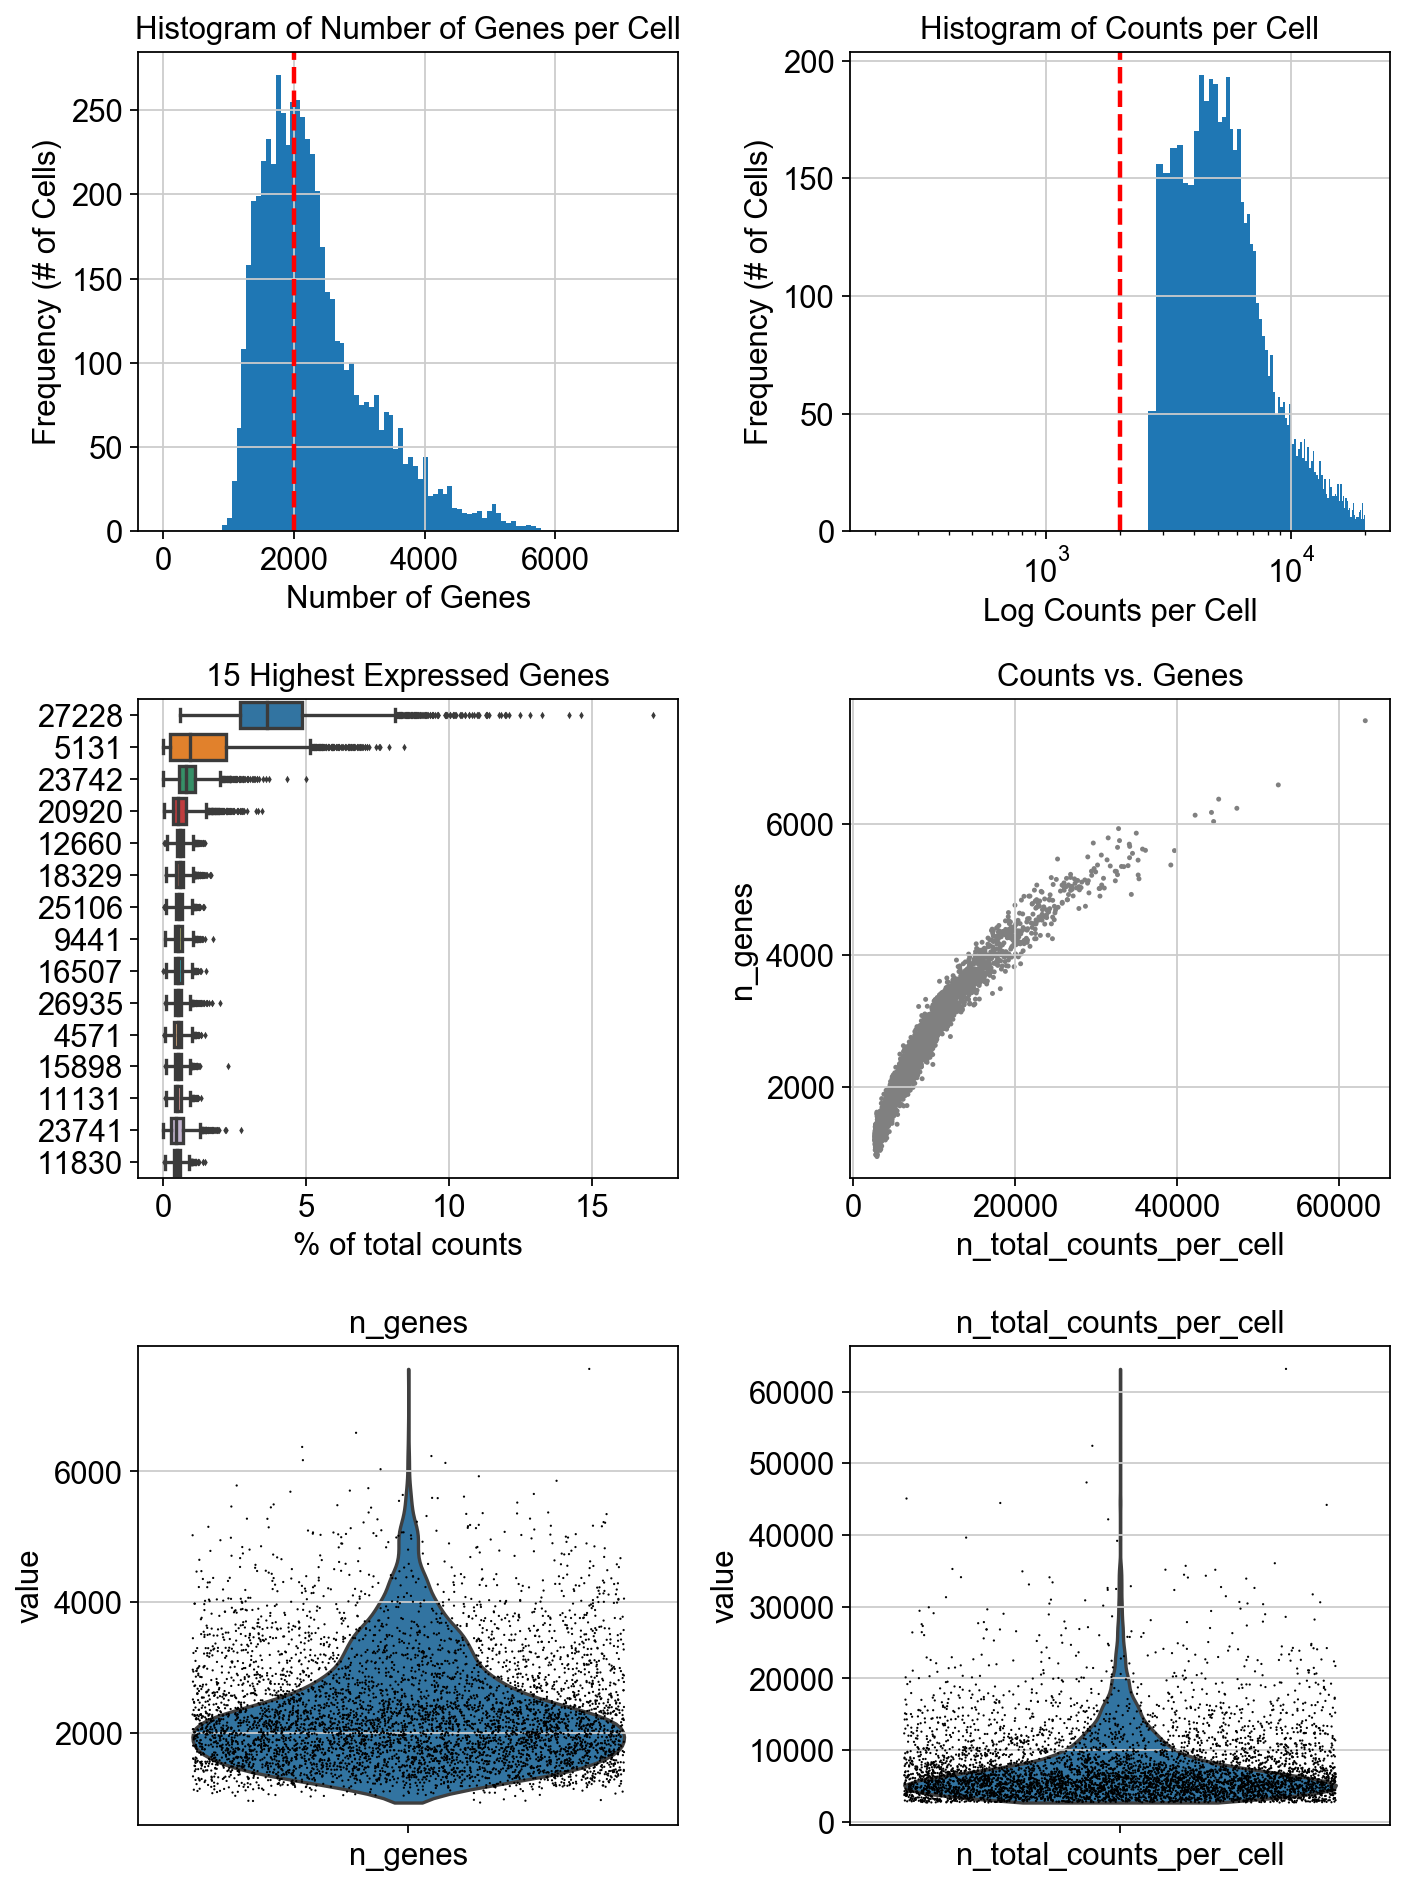

In [15]:
print('Post Natural Involution Mammary Gland Epithelial Cells Pre-Processing')
sc.pp.filter_cells(pi_adata, min_genes=0)
sc.pp.filter_genes(pi_adata, min_cells=0)

X = np.matrix(pi_adata.X)

# Total counts, cells per gene, and mitochondrial genes
pi_adata.obs['n_total_counts_per_cell'] = X.sum(axis=1).A1
pi_adata.var['n_cells_per_gene'] = X.astype(bool).astype(int).sum(axis=0).A1
pi_adata.obs['n_genes_per_cell'] = X.astype(bool).astype(int).sum(axis=1).A1

fig, ax = plt.subplots(3, 2, figsize = (9, 12))

ax[0,0].hist(pi_adata.obs['n_genes_per_cell'][:], bins = 100, range = (0, 7500))
ax[0,0].set_title('Histogram of Number of Genes per Cell')
ax[0,0].set_xlabel('Number of Genes')
ax[0,0].set_ylabel('Frequency (# of Cells)')
ax[0,0].axvline(x=2000, color='r', linestyle='dashed', linewidth=2)

ax[0,1].hist(pi_adata.obs['n_total_counts_per_cell'][:], 
             bins = 100, range = (0, 20000))
ax[0,1].set_title('Histogram of Counts per Cell')
ax[0,1].set_xlabel('Log Counts per Cell')
ax[0,1].set_ylabel('Frequency (# of Cells)')
ax[0,1].set_xscale('log')
ax[0,1].axvline(x=2000, color='r', linestyle='dashed', linewidth=2)


sc.pl.highest_expr_genes(pi_adata, n_top=15, ax=ax[1,0], show=False)
ax[1,0].set_title('15 Highest Expressed Genes')
sc.pl.scatter(pi_adata, x='n_total_counts_per_cell', y='n_genes', size = 20, 
              title = 'Counts vs. Genes', ax=ax[1,1], show=False)

sc.pl.violin(pi_adata, keys='n_genes', jitter=0.4, show = False, ax=ax[2,0])
ax[2,0].set_title('n_genes')
sc.pl.violin(pi_adata, keys='n_total_counts_per_cell', jitter=0.4, show = False, ax=ax[2,1])
ax[2,1].set_title('n_total_counts_per_cell')
fig.tight_layout()

In [16]:
sc.pp.filter_cells(pi_adata, min_genes = 759)

In [17]:
adatas = [np_adata, l_adata, pi_adata, g_adata]
adata = adatas[0].concatenate(adatas[1:])
adata

AnnData object with n_obs × n_vars = 25010 × 27998 
    obs: 'batch', 'n_genes', 'n_genes_per_cell', 'n_total_counts_per_cell', 'tissue'
    var: 'gene_ids', 'n_cells-0', 'n_cells_per_gene-0', 'n_cells-1', 'n_cells_per_gene-1', 'n_cells-2', 'n_cells_per_gene-2', 'n_cells-3', 'n_cells_per_gene-3'

In [18]:
to_del = ['n_cells-0', 'n_cells_per_gene-0', 'n_cells-1', 'n_cells_per_gene-1', 'n_cells-2', 'n_cells_per_gene-2', 'n_cells-3', 'n_cells_per_gene-3']
for i in to_del:
    del adata.var[i]

In [19]:
adata

AnnData object with n_obs × n_vars = 25010 × 27998 
    obs: 'batch', 'n_genes', 'n_genes_per_cell', 'n_total_counts_per_cell', 'tissue'
    var: 'gene_ids'

The plots above allow us to visualize parameters for our data set, including the number of unique cells and genes captured in the data set, and the distributions of the total number of counts per cell, the total numbers of genes per cell, and the total number of cells per gene. These will allow us to determine our parameters for filtering our data set so we can retain only cells and genes desired.

Below, we adjust the parameters for filtering our cells (based on minimum total counts and the minimum number of genes per cell) and our genes (based on the minimum number of cells the gene is detected in). A high-quality data set for cells has an average of 20,000 counts per cell,  1000-2000 genes per cell, and about 3,000 cells per gene. We can filter genes as some fraction of the total cell count.

filtered out 8751 genes that are detected in less than 3 cells


... storing 'tissue' as categorical


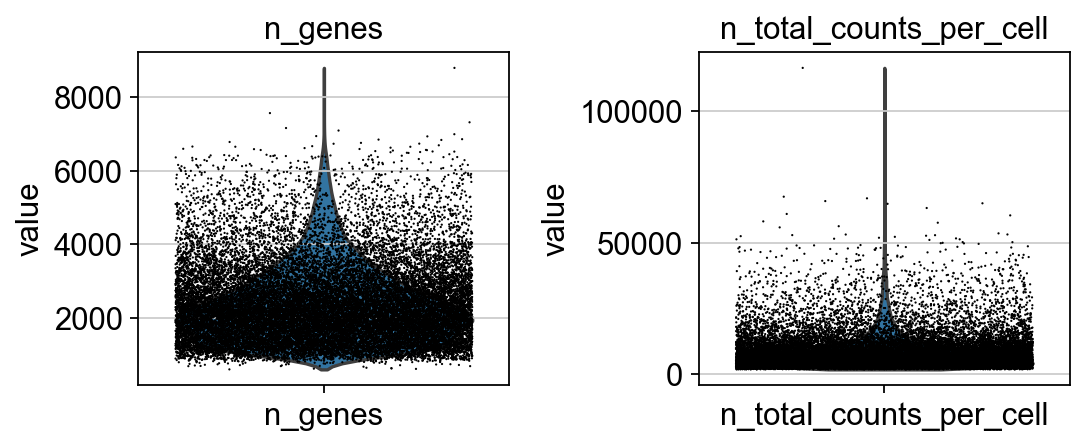

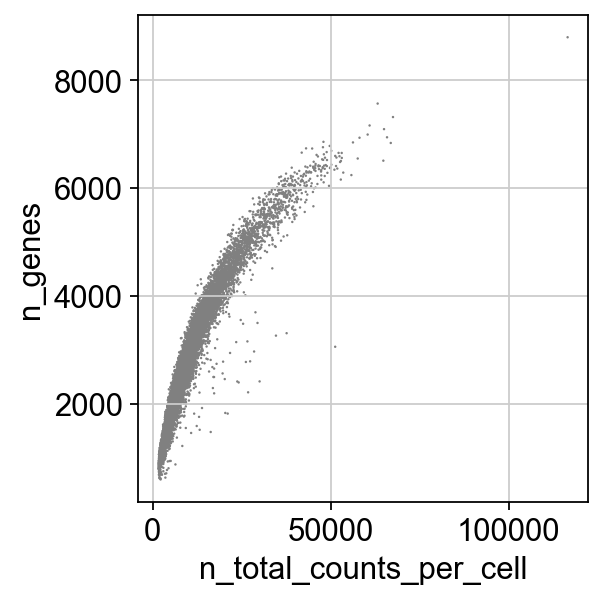

In [20]:
# Filter out cells and genes based on number of genes, percent mitochondrial genes
# Total count noramlize the data, logarithmize it, and identify highly variable genes. 

# We need to check the parameters for min_counts and min_genes from our histograms
#sc.pp.filter_cells(adata, min_counts = 2000)
#sc.pp.filter_cells(adata, max_counts = 65000)

X = np.matrix(adata.X)

# Total counts, cells per gene, and mitochondrial genes
adata.obs['n_total_counts_per_cell'] = X.sum(axis=1).A1
adata.var['n_cells_per_gene'] = X.astype(bool).astype(int).sum(axis=0).A1
adata.obs['n_genes_per_cell'] = X.astype(bool).astype(int).sum(axis=1).A1

# for the input, refer to the initial number of cells in the dataset
sc.pp.filter_genes(adata, min_cells=int(3)) # paper filters out genes in fewer than 3 cells

fig,ax = plt.subplots(1, 2, figsize = (7, 3))
sc.pl.violin(adata, keys='n_genes', jitter=0.4, show = False, ax=ax[0])
ax[0].set_title('n_genes')
sc.pl.violin(adata, keys='n_total_counts_per_cell', jitter=0.4, show = False, ax=ax[1])
ax[1].set_title('n_total_counts_per_cell')
fig.tight_layout()
sc.pl.scatter(adata, x='n_total_counts_per_cell', y='n_genes')
ax[1].axvline(x=70000, color='r', linestyle='dashed', linewidth=2)

normalizing counts per cell
    finished (0:00:10)
extracting highly variable genes
    finished (0:00:14)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


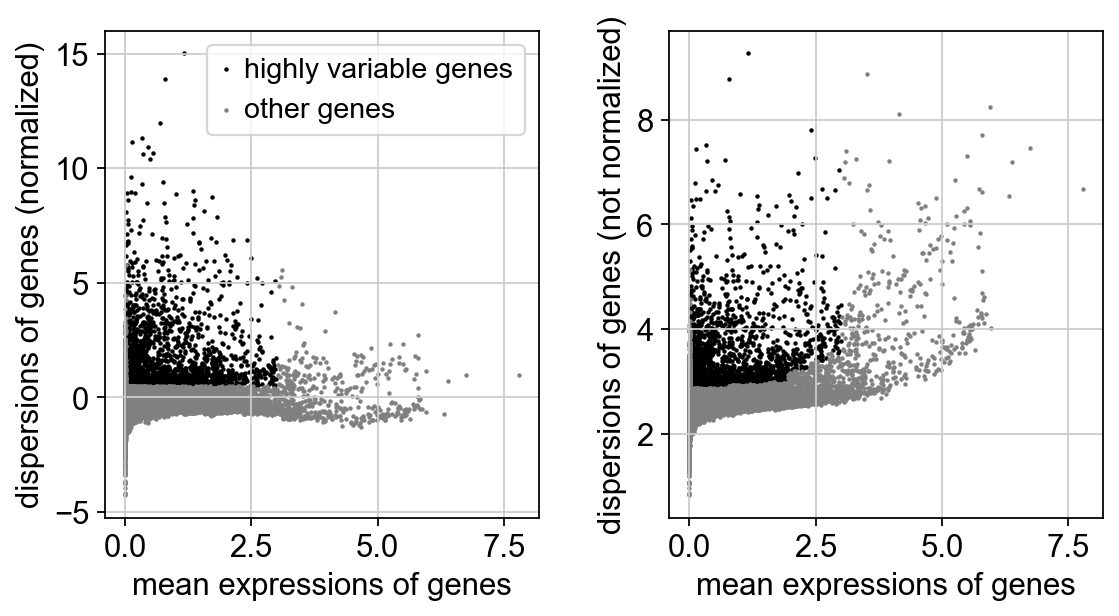

In [21]:
# Base parameters on above values
# Actually do the filtering
adata = adata[adata.obs.n_genes < 8000, :] 

# Total count normalize
sc.pp.normalize_total(adata, target_sum=70000) # paper normalizes to n_counts/10

# Logarithmize the data
sc.pp.log1p(adata)

# Set raw to store unnormalized data
adata.raw = adata

# Identify our highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

Below, we should input the genes used as markers for clustering in the reference paper. Moreover, we determine which Wnt, Bmp, and Notch pathway receptors and ligands are present in our dataset, and store these values.

In [22]:
# Which Wnt, Bmp, and Notch pathway genes are in our filtered dataset
# Also save the names of genes that the paper uses

wnts = adata.var_names.str.startswith('Wnt')
wnt_ligands = list(adata.var_names[wnts])

fzd = adata.var_names.str.startswith('Fzd')
fzd_receptors = list(adata.var_names[fzd])

lrp5 = adata.var_names.str.startswith('Lrp5')
lrp6 = adata.var_names.str.startswith('Lrp6')
lrp_receptors = list(adata.var_names[lrp5]) + list(adata.var_names[lrp6])

wnt_receptors = fzd_receptors + lrp_receptors

wnt_pathway = wnt_ligands + wnt_receptors

joint_genes = adata.var.highly_variable + wnts + fzd + lrp5 + lrp6

bmpr = ["Bmpr1a" ,"Bmpr1b" ,"Acvr1"  ,"Acvrl1" ,"Acvr1b" ,"Tgfbr1" , "Acvr1c",
        "Acvr2a", "Acvr2b", "Bmpr2" ,"Tgfbr2"]
bmp_receptors = []

bmps = ['Bmp2', 'Bmp3', 'Bmp4', 'Bmp5', 'Bmp6', 'Bmp7', 'Bmp8a',
       'Bmp10', 'Bmp11', 'Bmp15', 'Gdf6', 'Gdf7', 'Gdf5', 'Gdf10',
       'Gdf11']
bmp_ligands = []

for i in bmpr:
    if True in adata.var_names.str.contains(i):
        bmp_receptors.append(i)
for i in bmps:
    if True in adata.var_names.str.contains(i):
        bmp_ligands.append(i)        
        
bmp_pathway = bmp_receptors + bmp_ligands
        
for i in bmp_receptors:
    joint_genes += adata.var_names.str.startswith(i)

for i in bmp_ligands:
    joint_genes += adata.var_names.str.startswith(i)
    
notch = ["Dll1",   "Dll3"   ,"Dll4",    "Jag1"  , "Jag2", "Notch1", "Notch2", 
         "Notch3", "Notch4", "Mfng",  "Rfng"  , "Lfng"]
notch_pathway = []

for i in notch:
    if True in adata.var_names.str.contains(i):
        notch_pathway.append(i)
for i in notch_pathway:
    joint_genes += adata.var_names.str.startswith(i)
    
marker_genes = ['Krt18', 'Krt5', 'Esr1', 'Prlr', 'Aldh1a3', 'Kit', 'Pgr', 'Csn2',
               'Acta2', 'Oxtr', 'Pdpn', 'Procr', 'Zeb2', 'Glycam1', 'Tead1',
               'Fosl1', 'Hmga1', 'Runx1', 'Tox2', 'Bhlhe41', 'Elf5', 'Foxs1', 'Ehf']

for marker in marker_genes:
    joint_genes += adata.var_names.str.startswith(marker)
        
adata = adata[:, joint_genes]

genes_of_interest = wnt_pathway + bmp_pathway + notch_pathway

Next, we regress our data on the total number of counts per cell. We then scale our data set by centering each gene's expression with zero mean and unit variance, and filter out any genes whose standard deviation for expression is greater than 10. 

In [23]:
# Regress out effects of total counts per cell and percent mitochondrial genes
sc.pp.regress_out(adata, ['n_total_counts_per_cell'])

# Scale genes to unit variance and remove values with SD > 10
sc.pp.scale(adata)

regressing out ['n_total_counts_per_cell']
    finished (0:01:03)


In [24]:
adata

AnnData object with n_obs × n_vars = 25009 × 2631 
    obs: 'batch', 'n_genes', 'n_genes_per_cell', 'n_total_counts_per_cell', 'tissue'
    var: 'gene_ids', 'n_cells_per_gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

### Principal component analysis

We perform principal component analysis on the processed data set. This transforms the data to a new linear space and defines a "best-fitting line" for multi-dimensional data. Below, we also plot the variance ratio of the principal components to determine the minimum number of principal components we must select for dimensionality reduction.

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:06)


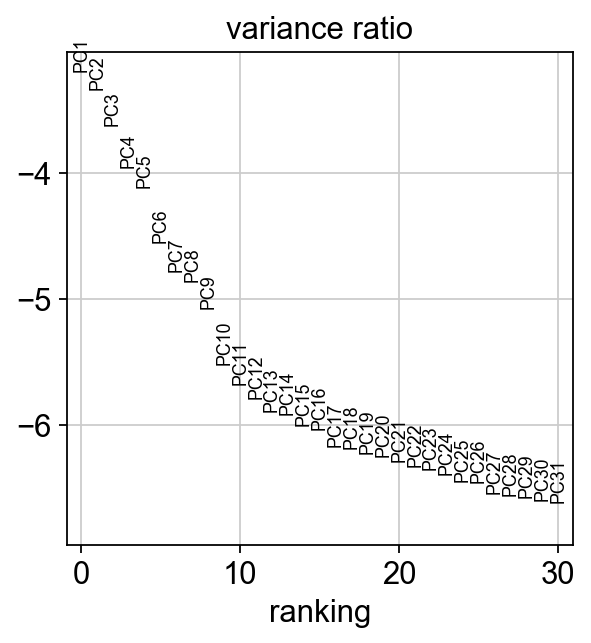

In [25]:
#from anndata import AnnData
sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True)

# Save these results
adata.write(results_file)

### Computing the Neighborhood Graph and UMAPs

We can compute a neighborhood graph of cells using a PCA representation of our data matrix. We can then use the UMAP method for dimensionality reduction and visualization. We can appropriately adjust the number of principal components we select based on the above variance ratio plot.

In [26]:
from anndata import AnnData
adatas = [adata[adata.obs['tissue'] == i].copy() for i in 
         ['np', 'l', 'g', 'pi']]
sc.external.pp.bbknn(adatas[0], 'batch')
sc.external.pp.bbknn(adatas[1], 'batch')
sc.external.pp.bbknn(adatas[2], 'batch')
sc.external.pp.bbknn(adatas[3], 'batch')

adata = AnnData.concatenate(adatas[0], adatas[1], adatas[2], adatas[3])

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:03)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)


In [27]:
adata

AnnData object with n_obs × n_vars = 25009 × 2631 
    obs: 'batch', 'n_genes', 'n_genes_per_cell', 'n_total_counts_per_cell', 'tissue'
    var: 'gene_ids', 'n_cells_per_gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca'

In [28]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


### Clustering

We can use the Leiden method for clustering our data.

running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:08)


... storing 'tissue' as categorical


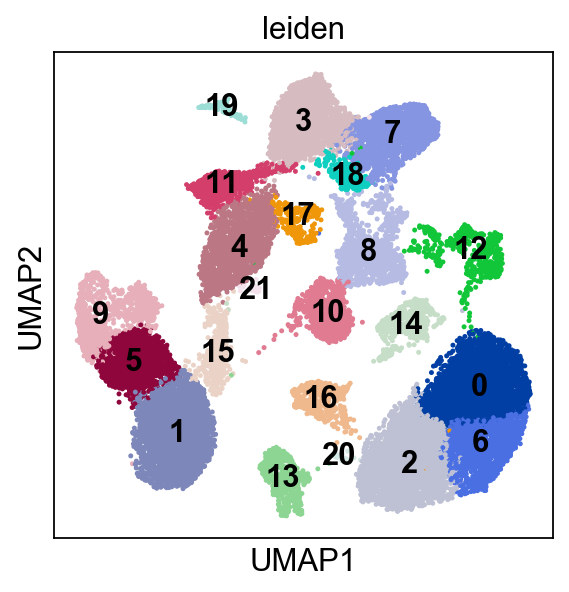

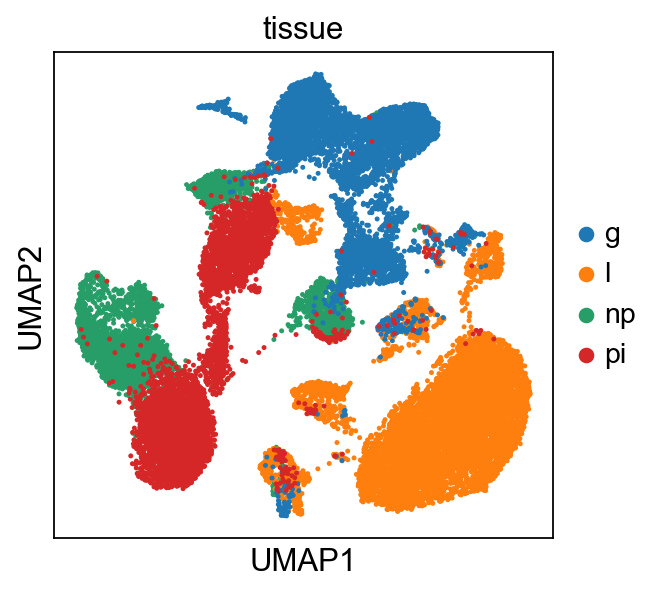

In [29]:
sc.tl.leiden(adata)

sc.pl.umap(adata, color= 'leiden', 
           save = '_clusters.pdf', legend_loc = 'on data',
          size = 20)

sc.pl.umap(adata, color= 'tissue', 
           save = '_tissue.pdf', size = 20)

#adata.write(results_file)

KeyError: 'Krt5'

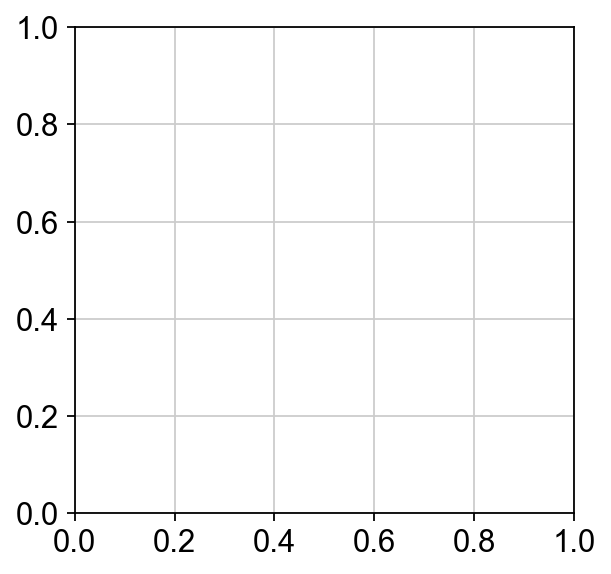

In [31]:
#sc.pl.umap(adata, color= 'Krt18', 
          # save = '_Krt18.pdf', size = 20)

sc.pl.umap(adata, color= 'Krt5', 
           save = '_Krt5.pdf', size = 20)

### Marker Genes and Cell Type Clustering

We need to annotate the cell types our clusters correspond to. Papers frequently define cell types by marker genes. To score clusters based on marker genes, we define functions that return z-scores for clusters corresponding to specific cell-types. We can also provide z-scores for specific marker genes for each cluster. Based on these z-scores, we can assign cell type. 

In [21]:
marker_genes = {
    'Primitive erythroid': ['Hba-x', 'Hba-y', 'Hbb-bh1', 'B2m'],
    'Primitive macrophage': ['Cst3', 'Csfr1'],
    'EMP': ['Kit'],
    'Definitive erythroid': ['Sox6'],
    'Myeloid progenitors': ['Itga2b']
}

In [22]:
# This scores each cluster based on marker genes that define the clusters in literature

def evaluate_partition(anndata, marker_dict, gene_symbol_key=None, partition_key='leiden'):
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' 

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = np.unique(anndata.obs[partition_key])
    n_clust = len(clusters)
    n_groups = len(marker_dict)
    
    marker_res = np.zeros((n_groups, n_clust))
    z_scores = sc.pp.scale(anndata, copy=True)

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        j = 0
        for clust in clusters:
            cluster_cells = np.in1d(z_scores.obs[partition_key], clust)
            marker_genes = np.in1d(gene_ids, marker_dict[group])
            marker_res[i,j] = z_scores.X[np.ix_(cluster_cells,marker_genes)].mean()
            j += 1
        i+=1

    variances = np.nanvar(marker_res, axis=0)
    if np.all(np.isnan(variances)):
        print("No variances could be computed, check if your cell markers are in the data set.")
        print("Maybe the cell marker IDs do not correspond to your gene_symbol_key input or the var_names")
        raise

    marker_res_df = pd.DataFrame(marker_res, columns=clusters, index=marker_dict.keys())

    #Return the median of the variances over the clusters
    #return([np.median(variances), marker_res_df])
    return(marker_res_df)

In [23]:
evaluate_partition(heme, marker_genes)

0         1         2         3         4  \
Primitive erythroid  -0.048996  0.767675  0.199092 -0.164351 -0.221859   
Primitive macrophage -0.440947 -0.635582  1.973039  0.295494 -0.515195   
EMP                   0.905353 -0.782384 -0.821234  0.949733 -0.479280   
Definitive erythroid -0.194949 -0.451775 -0.462833 -0.267901  1.850676   
Myeloid progenitors   0.187371 -0.196748 -0.709655  0.759850 -0.564194   

                             5         6         7         8  
Primitive erythroid  -0.340280 -0.604966 -0.135706  0.550712  
Primitive macrophage -0.311097 -0.490589  0.091259 -0.140150  
EMP                   0.611367 -0.170920 -0.252239 -0.866987  
Definitive erythroid  0.005834  0.274864 -0.498682 -0.214862  
Myeloid progenitors  -0.400633 -0.657250  2.502830 -0.001007

In [24]:
# This scores each cluster on marker genes

def marker_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='leiden'):
    """
    A function to get mean z-score expressions of marker genes
    # 
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' 
    """

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        
    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = anndata.obs[partition_key].cat.categories
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []
    
    z_scores = sc.pp.scale(anndata, copy=True)

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        for gene in marker_dict[group]:
            ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
            if np.sum(ens_idx) == 0:
                continue
            else:
                z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
                ens_idx = ens_idx[0]

            clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
            clust_marker_exp.append(group)
            marker_exp.loc[i] = clust_marker_exp
            marker_names.append(gene)
            i+=1

    #Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return(marker_exp)

In [25]:
df = marker_gene_expression(heme, marker_genes)

marker_genes = list(df.index)

df

0         1         2         3         4         5         6  \
Hba-x   -0.163239  1.834013 -0.462202 -0.562478 -0.240488 -0.489619 -0.660620   
Hbb-bh1  0.136392  1.619866 -0.633868 -0.559126  0.025754 -0.458307 -0.878810   
B2m     -0.120141 -1.150853  1.693347  0.628551 -0.450843 -0.072914 -0.275469   
Cst3    -0.440947 -0.635582  1.973039  0.295494 -0.515195 -0.311097 -0.490589   
Kit      0.905353 -0.782384 -0.821234  0.949733 -0.479280  0.611367 -0.170920   
Sox6    -0.194949 -0.451775 -0.462833 -0.267901  1.850676  0.005834  0.274864   
Itga2b   0.187371 -0.196748 -0.709655  0.759850 -0.564194 -0.400633 -0.657250   

                7         8             cell_type  
Hba-x   -0.280302  1.586426   Primitive erythroid  
Hbb-bh1 -0.302793  1.368071   Primitive erythroid  
B2m      0.175976 -1.302360   Primitive erythroid  
Cst3     0.091259 -0.140150  Primitive macrophage  
Kit     -0.252239 -0.866987                   EMP  
Sox6    -0.498682 -0.214862  Definitive erythroid  
Itga2b   2.502830 -0.001007   Myeloid progenitors

In [26]:
# Eliminate small or outlier clusters

heme = heme[~heme.obs['leiden'].isin(['9']),:]

Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical


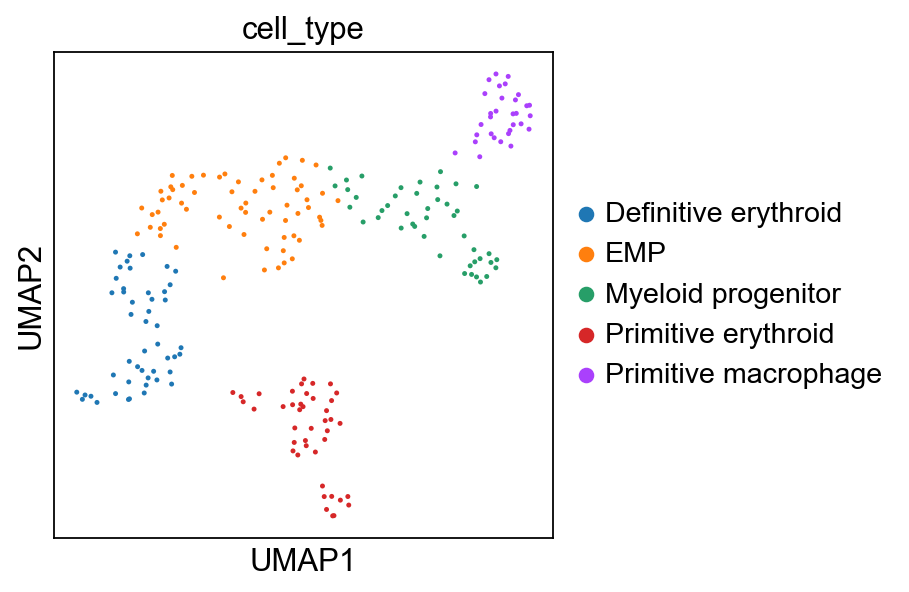

In [27]:
# Define cell types based on cluster scores

old_to_new = {
    '1': 'Primitive erythroid',
    '8': 'Primitive erythroid',
    '2': 'Primitive macrophage',
    '0': 'EMP',
    '5': 'EMP',
    '4': 'Definitive erythroid',
    '6': 'Definitive erythroid',
    '3': 'Myeloid progenitor',
    '7': 'Myeloid progenitor'
}

heme.obs['cell_type'] = heme.obs['leiden'].replace(old_to_new)

sc.pl.umap(heme, color= 'cell_type', save = '_cell_type.pdf', size = 20) 

### UMAPs, Heatmaps and Dotplots

In order to determine Wnt, Bmp, and Notch expression profiles in the different clusters of our dataset, we plot the UMAPs. We can also compare relative expression with heatmaps, and determine the percentage of cells in a cluster that express a given gene using dotplots.

In [28]:
# Wnt plots

with PdfPages('./datasets/epithelial_mesenchymal_transition/heme/figures/wnt_plots.pdf') as pdf:
    wnt_umaps = sc.pl.umap(heme, color = wnt_pathway, size = 100, show = False)
    wnt_figs = plt.gcf()
    wnt_figs.savefig(pdf, format = 'pdf')
    plt.close()

    wnt_matrix = sc.pl.matrixplot(heme, groupby='cell_type', 
                 var_names = wnt_pathway, show = False)
    wnt_figs = plt.gcf() 
    wnt_figs.savefig(pdf, format = 'pdf', bbox_inches='tight', dpi = 300)
    plt.close()

    wnt_dot = sc.pl.dotplot(heme, groupby='cell_type', 
                 var_names = wnt_pathway, show = False)
    wnt_figs = plt.gcf()
    wnt_figs.savefig(pdf, format = 'pdf', bbox_inches='tight')
    plt.close()

In [29]:
# Bmp plots

with PdfPages('./datasets/epithelial_mesenchymal_transition/heme/figures/bmp_plots.pdf') as pdf:
    bmp_umaps = sc.pl.umap(heme, color = bmp_pathway, size = 100, show = False)
    bmp_figs = plt.gcf()
    bmp_figs.savefig(pdf, format = 'pdf')
    plt.close()

    bmp_matrix = sc.pl.matrixplot(heme, groupby='cell_type', 
                 var_names = bmp_pathway, show = False)
    bmp_figs = plt.gcf() 
    bmp_figs.savefig(pdf, format = 'pdf', bbox_inches='tight', dpi = 300)
    plt.close()

    bmp_dot = sc.pl.dotplot(heme, groupby='cell_type', 
                 var_names = bmp_pathway, show = False)
    bmp_figs = plt.gcf()
    bmp_figs.savefig(pdf, format = 'pdf', bbox_inches='tight')
    plt.close()

In [30]:
# Notch plots

with PdfPages('./datasets/epithelial_mesenchymal_transition/heme/figures/notch_plots.pdf') as pdf:
    notch_umaps = sc.pl.umap(heme, color = notch_pathway, size = 100, show = False)
    notch_figs = plt.gcf()
    notch_figs.savefig(pdf, format = 'pdf')
    plt.close()

    notch_matrix = sc.pl.matrixplot(heme, groupby='cell_type', 
                 var_names = notch_pathway, show = False)
    notch_figs = plt.gcf() 
    notch_figs.savefig(pdf, format = 'pdf', bbox_inches='tight', dpi = 300)
    plt.close()

    notch_dot = sc.pl.dotplot(heme, groupby='cell_type', 
                 var_names = notch_pathway, show = False)
    notch_figs = plt.gcf()
    notch_figs.savefig(pdf, format = 'pdf', bbox_inches='tight')
    plt.close()

In [31]:
# Marker plots

with PdfPages('./datasets/epithelial_mesenchymal_transition/heme/figures/marker_plots.pdf') as pdf:
    marker_umaps = sc.pl.umap(heme, color = marker_genes, size = 100, show = False)
    marker_figs = plt.gcf()
    marker_figs.savefig(pdf, format = 'pdf')
    plt.close()

    marker_matrix = sc.pl.matrixplot(heme, groupby='cell_type', 
                 var_names = marker_genes, show = False)
    marker_figs = plt.gcf() 
    marker_figs.savefig(pdf, format = 'pdf', bbox_inches='tight', dpi = 300)
    plt.close()

    marker_dot = sc.pl.dotplot(heme, groupby='cell_type', 
                 var_names = marker_genes, show = False)
    marker_figs = plt.gcf()
    marker_figs.savefig(pdf, format = 'pdf', bbox_inches='tight')
    plt.close()

## Signaling Profiles

We can define signaling profiles for the Wnt, Bmp, and Notch pathways, by clustering gene expression profiles for our different Leiden clusters. We can calculate the best number of clusters/signaling profiles by using silhouette scores. Based on these silhouette scores, I label the cells with signaling profile "clusters" for each pathway.

In [32]:
def gene_expression(anndata, marker_list, gene_symbol_key=None, partition_key='leiden'):
    """A function go get mean z-score expressions of marker genes
    # 
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' """

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        
    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = anndata.obs[partition_key].cat.categories
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    #marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []
    
    z_scores = sc.pp.scale(anndata, copy=True)

    i = 0
    
    for gene in marker_list:
        ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
        if np.sum(ens_idx) == 0:
            continue
        else:
            z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
            ens_idx = ens_idx[0]

        clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
        #clust_marker_exp.append(group)
        marker_exp.loc[i] = clust_marker_exp
        marker_names.append(gene)
        i+=1

    #Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return(marker_exp)

In [33]:
def silhouette_graphs(range_n_clusters, X):
    '''This function provides a silhouette score and graph of gene expression data from a 
    clustermap for 2-(#clusters - 1) groupings'''
    figs = []
    for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        #print("For n_clusters =", n_clusters,
          #"The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
            ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle("Silhouette analysis for KMeans clustering on data"
                  "with n_clusters = %d" % n_clusters +  
          " with average silhouette_score: %f10" % silhouette_avg,
                 fontsize=14, fontweight='bold')
        figs.append(fig)
    return figs

In [34]:
def silhouette_analysis(range_n_clusters, X):
    '''This function provides a silhouette score of gene expression data from a clustermap 
    for 2-(#clusters - 1) groupings'''
    scores = []
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append((n_clusters,silhouette_avg))
    return scores

In [35]:
# Silhouette scores for different numbers of expression trajectories for Wnt, Bmp, and Notch
# pathways. 

pathways = ['wnt_dendrogram', 'bmp_dendrogram', 'notch_dendrogram']
pathway_genes = [wnt_pathway, bmp_pathway, notch_pathway]
range_n_clusters = list(range(2,len(heme.obs['leiden'].unique())))
scores = pd.DataFrame()

for i in range(0,len(pathways)):
    df = gene_expression(heme, pathway_genes[i])
    g = sns.clustermap(df, metric='cosine', row_cluster=False, cmap='viridis');
    ax = g.ax_heatmap
    ax.set_title(pathways[i])
    ax.set_xlabel('Leiden clustering')
    plt.savefig('./datasets/epithelial_mesenchymal_transition/heme/figures/'+pathways[i]+'.pdf')
    plt.close()
    df.reset_index(inplace=True)
    X = df[df.columns[1:]].values
    score = silhouette_analysis(range_n_clusters, X)
    scores[pathways[i]] = [s[1] for s in score]
new_dict = dict(zip(scores.index.values, range_n_clusters))
scores.rename(new_dict)

wnt_dendrogram  bmp_dendrogram  notch_dendrogram
2        0.472536        0.474860          0.186774
3        0.301137        0.340270          0.269430
4        0.309074        0.335615          0.364071
5        0.302532        0.315460          0.367398
6        0.304966        0.300403          0.344706
7        0.289960        0.221326          0.309603
8        0.298746        0.141293          0.279444

In [36]:
# Wnt signaling clusters
df = gene_expression(heme, pathway_genes[0])
d = sch.distance.pdist(df.transpose(), metric='cosine')
L=sch.linkage(d)
linkage = sch.fcluster(L, 2,'maxclust')
new_dict = dict(zip([str(i) for i in range(0,len(linkage))], linkage))
heme.obs['wnt_cluster'] = heme.obs['leiden'].replace(new_dict)

In [37]:
# Bmp signaling clusters
df = gene_expression(heme, pathway_genes[1])
d = sch.distance.pdist(df.transpose(), metric='cosine')
L=sch.linkage(d)
linkage = sch.fcluster(L, 2,'maxclust')
new_dict = dict(zip([str(i) for i in range(0,len(linkage))], linkage))
heme.obs['bmp_cluster'] = heme.obs['leiden'].replace(new_dict)

In [38]:
# Notch signaling clusters
df = gene_expression(heme, pathway_genes[2])
d = sch.distance.pdist(df.transpose(), metric='cosine')
L=sch.linkage(d)
linkage = sch.fcluster(L, 5,'maxclust')
new_dict = dict(zip([str(i) for i in range(0,len(linkage))], linkage))
heme.obs['notch_cluster'] = heme.obs['leiden'].replace(new_dict)

### Pseudotime Analysis

We can do pseudotime analysis to observe developmental trajectories, and to observe how the gene expression profile changes over development. 

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


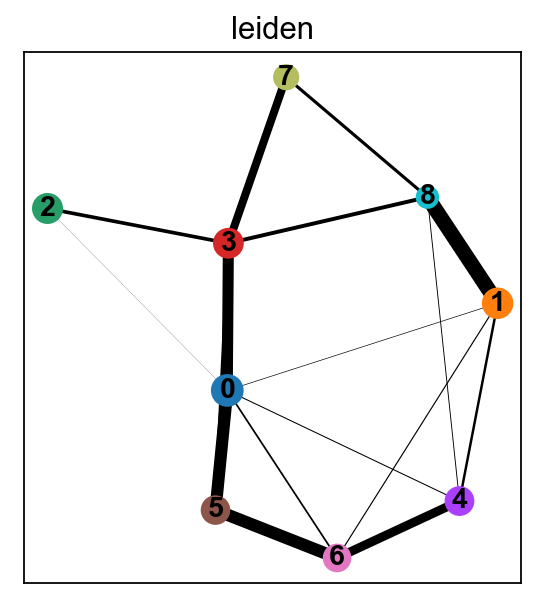

In [39]:
sc.tl.paga(heme, groups = 'leiden')
sc.pl.paga(heme, color= 'leiden', title = 'leiden', save = '.pdf')

Below are plots of the PAGA nodes colored by the Wnt, Bmp, and Notch expression profiles.

--> added 'pos', the PAGA positions (adata.uns['paga'])


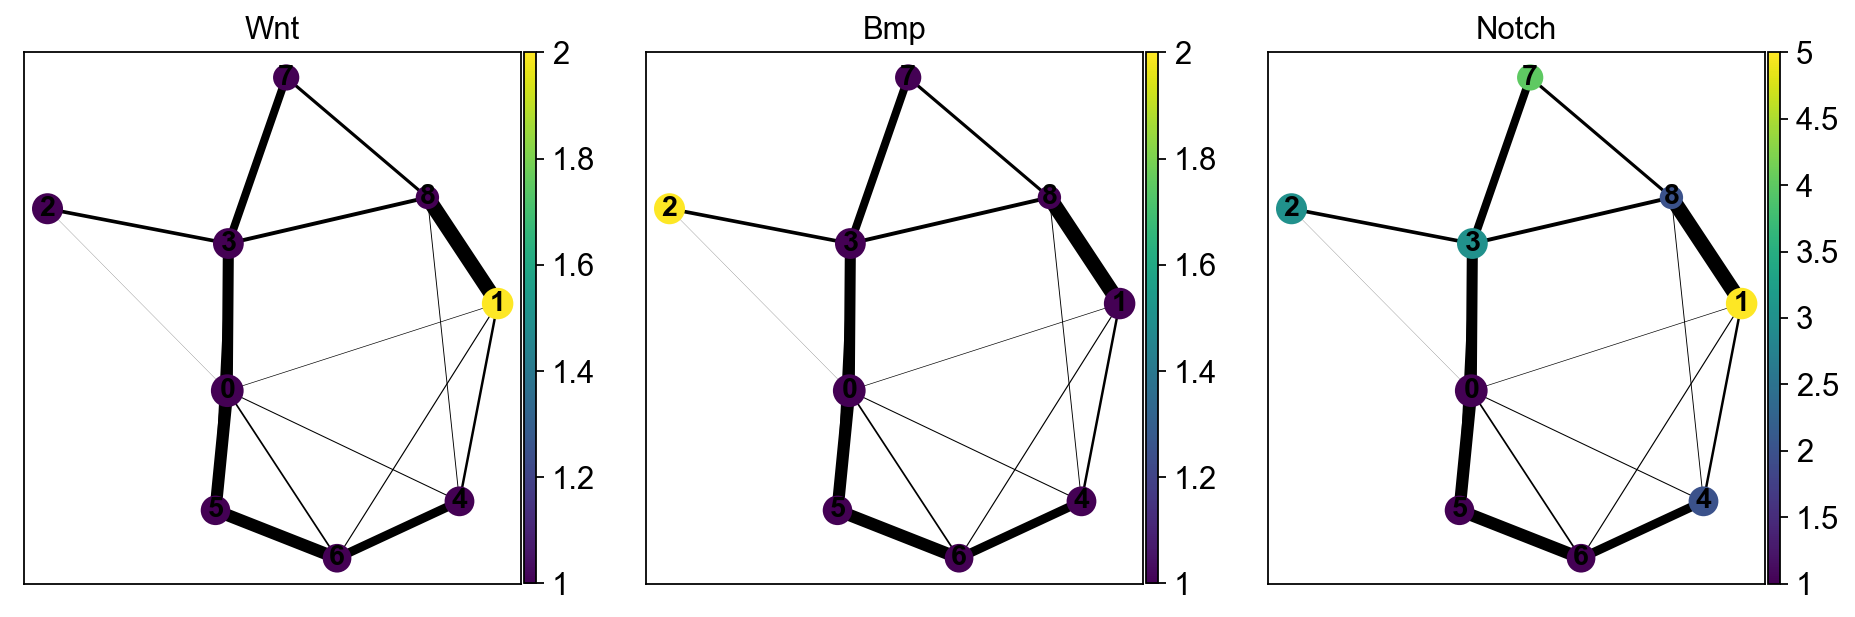

In [40]:
sc.pl.paga(heme, color=['wnt_cluster','bmp_cluster','notch_cluster'], title=['Wnt', 'Bmp', 'Notch'], 
           save='_expression_clusters.pdf')

Plotted below is a single-cell umap as a function of pseudotime.

In [41]:
# Define the root cell

heme.uns['iroot'] = np.flatnonzero(heme.obs['leiden']== '1')[0]
sc.tl.dpt(heme)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9859919  0.9775467  0.9691558  0.9621268  0.93012834
     0.9216901  0.8884914  0.85913485 0.8179929  0.7925955  0.7790209
     0.7684148  0.7652763  0.75254816]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:00)


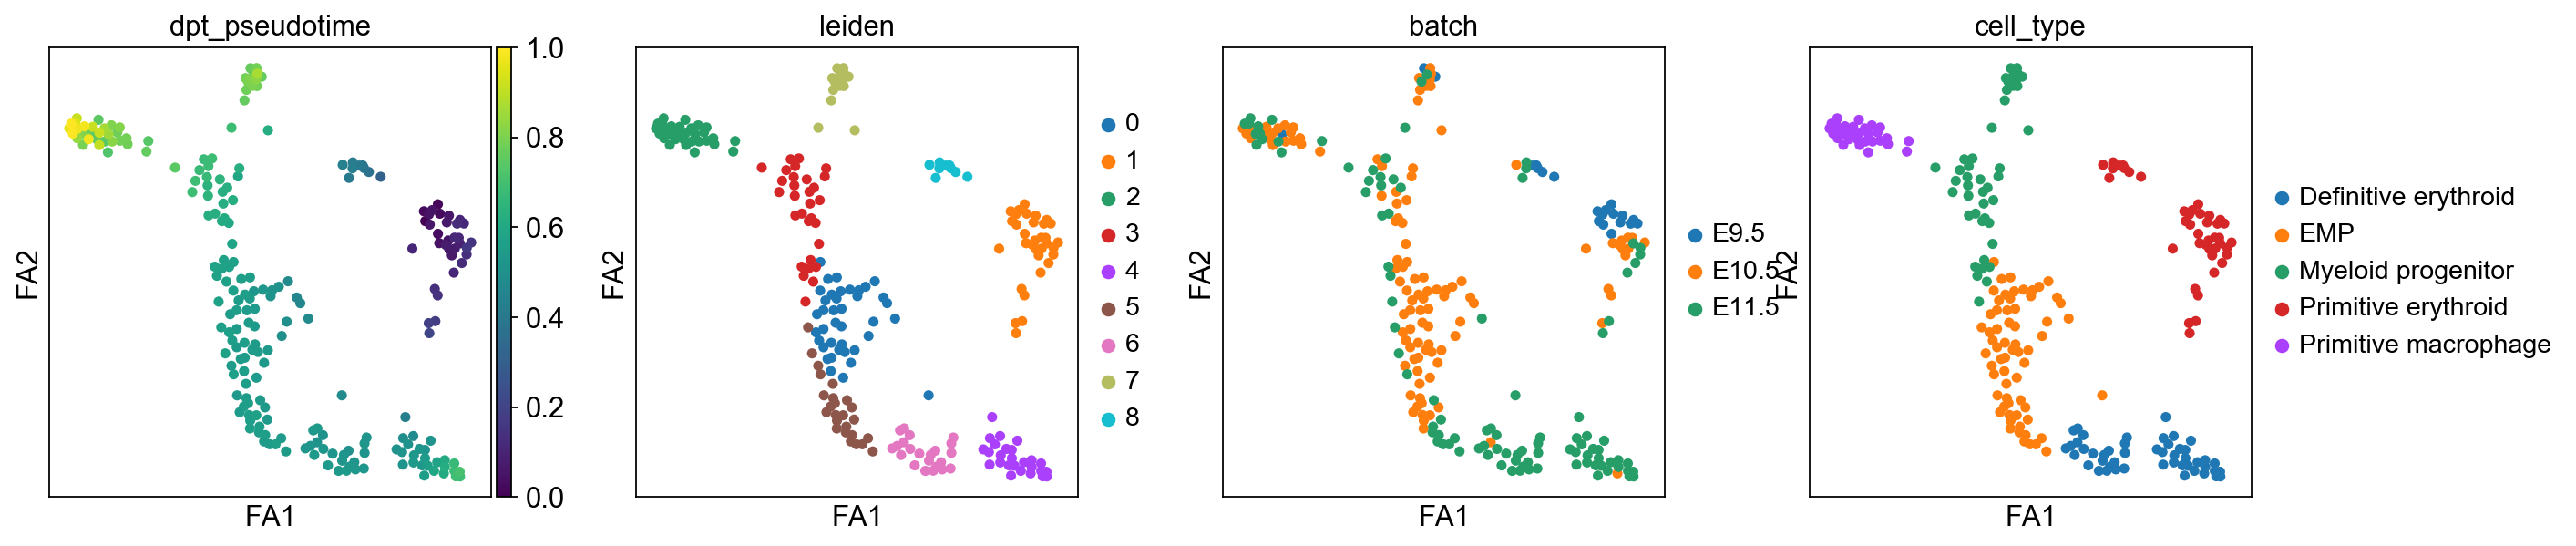

In [42]:
sc.tl.draw_graph(heme, init_pos='paga')
sc.pl.draw_graph(heme, color = ['dpt_pseudotime', 'leiden', 'batch', 'cell_type'], size = 100, save = '_pseudotime.pdf', show = True);

In [43]:
with PdfPages('./datasets/epithelial_mesenchymal_transition/heme/figures/wnt_pseudotime.pdf') as pdf:
    sc.pl.draw_graph(heme, color = wnt_pathway, size = 100, show = False)
    wnt_figs = plt.gcf()
    wnt_figs.savefig(pdf, format = 'pdf', bbox_inches='tight')
    plt.close()

In [44]:
with PdfPages('./datasets/epithelial_mesenchymal_transition/heme/figures/bmp_pseudotime.pdf') as pdf:
    sc.pl.draw_graph(heme, color = bmp_pathway, size = 100, show = False)
    bmp_figs = plt.gcf()
    bmp_figs.savefig(pdf, format = 'pdf', bbox_inches='tight')
    plt.close()

In [45]:
with PdfPages('./datasets/epithelial_mesenchymal_transition/heme/figures/notch_pseudotime.pdf') as pdf:
    sc.pl.draw_graph(heme, color = notch_pathway, size = 100, show = False)
    notch_figs = plt.gcf()
    notch_figs.savefig(pdf, format = 'pdf', bbox_inches='tight')
    plt.close()

In [46]:
with PdfPages('./datasets/epithelial_mesenchymal_transition/heme/figures/markers_pseudotime.pdf') as pdf:
    sc.pl.draw_graph(heme, color = marker_genes, size = 100, show = False)
    notch_figs = plt.gcf()
    notch_figs.savefig(pdf, format = 'pdf', bbox_inches='tight')
    plt.close()

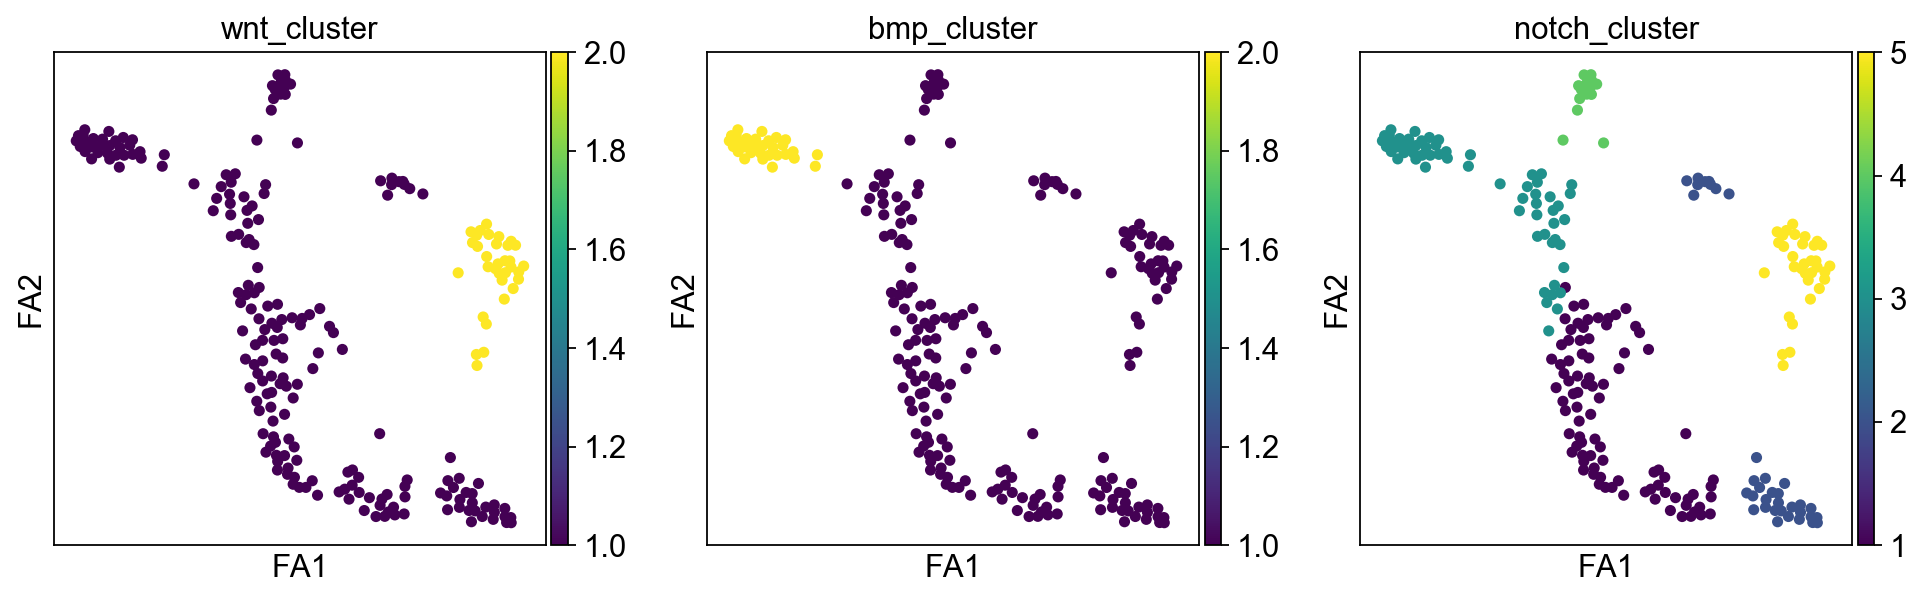

In [47]:
sc.pl.draw_graph(heme, color = ['wnt_cluster', 'bmp_cluster', 'notch_cluster'], size = 100, save = '_pst_expression.pdf', show = True);

In [48]:
wnt_pst_df = heme.obs['dpt_pseudotime'].to_frame()
wnt_pst_df['wnt_cluster'] = heme.obs['wnt_cluster']
for i in wnt_pathway:
    wnt_pst_df[i] = heme.X[0:,list(heme.var.index).index(i)]
wnt_pst_df = wnt_pst_df.sort_values('dpt_pseudotime')

In [49]:
bmp_pst_df = heme.obs['dpt_pseudotime'].to_frame()
bmp_pst_df['bmp_cluster'] = heme.obs['bmp_cluster']
for i in bmp_pathway:
    bmp_pst_df[i] = heme.X[0:,list(heme.var.index).index(i)]
bmp_pst_df = bmp_pst_df.sort_values('dpt_pseudotime')

In [50]:
notch_pst_df = heme.obs['dpt_pseudotime'].to_frame()
notch_pst_df['notch_cluster'] = heme.obs['notch_cluster']
for i in notch_pathway:
    notch_pst_df[i] = heme.X[0:,list(heme.var.index).index(i)]
notch_pst_df = notch_pst_df.sort_values('dpt_pseudotime')

In [51]:
for i in wnt_pst_df['wnt_cluster'].unique():
    with PdfPages('./datasets/epithelial_mesenchymal_transition/heme/figures/wnt_exp_cluster_'+str(i)+'.pdf') as pdf:
        df = wnt_pst_df[wnt_pst_df['wnt_cluster']==i]
        arrt = df['dpt_pseudotime'].to_numpy()
        avg_time = np.mean(arrt[:(len(arrt)//7)*7].reshape(-1,7), axis=1) # average every 7 elements
        for j in wnt_pathway:
            arrexp = df[j].to_numpy()
            avg_exp = np.mean(arrexp[:(len(arrexp)//7)*7].reshape(-1,7), axis=1) # avg every 7 elements
            plt.figure(figsize=(6,6),dpi=80)
            g=plt.scatter(avg_time, avg_exp)
            plt.title('Wnt Cluster '+str(i)+' Pseudotime Expression of '+str(j), size = 16)
            plt.xlabel('Pseudotime', size=14);
            plt.ylabel('Z-score Normalized Expression', size=14)
            g=plt.gcf()
            g.savefig(pdf, format='pdf')
            plt.close()

In [52]:
for i in bmp_pst_df['bmp_cluster'].unique():
    with PdfPages('./datasets/epithelial_mesenchymal_transition/heme/figures/bmp_exp_cluster_'+str(i)+'.pdf') as pdf:
        df = bmp_pst_df[bmp_pst_df['bmp_cluster']==i]
        arrt = df['dpt_pseudotime'].to_numpy()
        avg_time = np.mean(arrt[:(len(arrt)//7)*7].reshape(-1,7), axis=1) # average every 7 elements
        for j in bmp_pathway:
            arrexp = df[j].to_numpy()
            avg_exp = np.mean(arrexp[:(len(arrexp)//7)*7].reshape(-1,7), axis=1) # avg every 7 elements
            plt.figure(figsize=(6,6),dpi=80)
            g=plt.scatter(avg_time, avg_exp)
            plt.title('Bmp Cluster '+str(i)+' Pseudotime Expression of '+str(j), size = 16)
            plt.xlabel('Pseudotime', size=14);
            plt.ylabel('Z-score Normalized Expression', size=14)
            g=plt.gcf()
            g.savefig(pdf, format='pdf')
            plt.close()

In [53]:
for i in notch_pst_df['notch_cluster'].unique():
    with PdfPages('./datasets/epithelial_mesenchymal_transition/heme/figures/notch_exp_cluster_'+str(i)+'.pdf') as pdf:
        df = notch_pst_df[notch_pst_df['notch_cluster']==i]
        arrt = df['dpt_pseudotime'].to_numpy()
        avg_time = np.mean(arrt[:(len(arrt)//7)*7].reshape(-1,7), axis=1) # average every 7 elements
        for j in notch_pathway:
            arrexp = df[j].to_numpy()
            avg_exp = np.mean(arrexp[:(len(arrexp)//7)*7].reshape(-1,7), axis=1) # avg every 7 elements
            plt.figure(figsize=(6,6),dpi=80)
            g=plt.scatter(avg_time, avg_exp)
            plt.title('Notch Cluster '+str(i)+' Pseudotime Expression of '+str(j), size = 16)
            plt.xlabel('Pseudotime', size=14);
            plt.ylabel('Z-score Normalized Expression', size=14)
            g=plt.gcf()
            g.savefig(pdf, format='pdf')
            plt.close()

## Pretty Plots

In [54]:
df = pd.DataFrame(data=heme.obsm['X_umap'][0:,0:])
df.index = heme.obs.index
df.columns = ['x_umap', 'y_umap']
df.insert(2, "Batch", heme.obs['batch'])
df.insert(3, "cell_type", heme.obs['cell_type'])
df.insert(4, "x_pst", heme.obsm['X_draw_graph_fa'][:,0])
df.insert(5, "y_pst", heme.obsm['X_draw_graph_fa'][:,1])
df.insert(6, "pseudotime", heme.obs['dpt_pseudotime'])

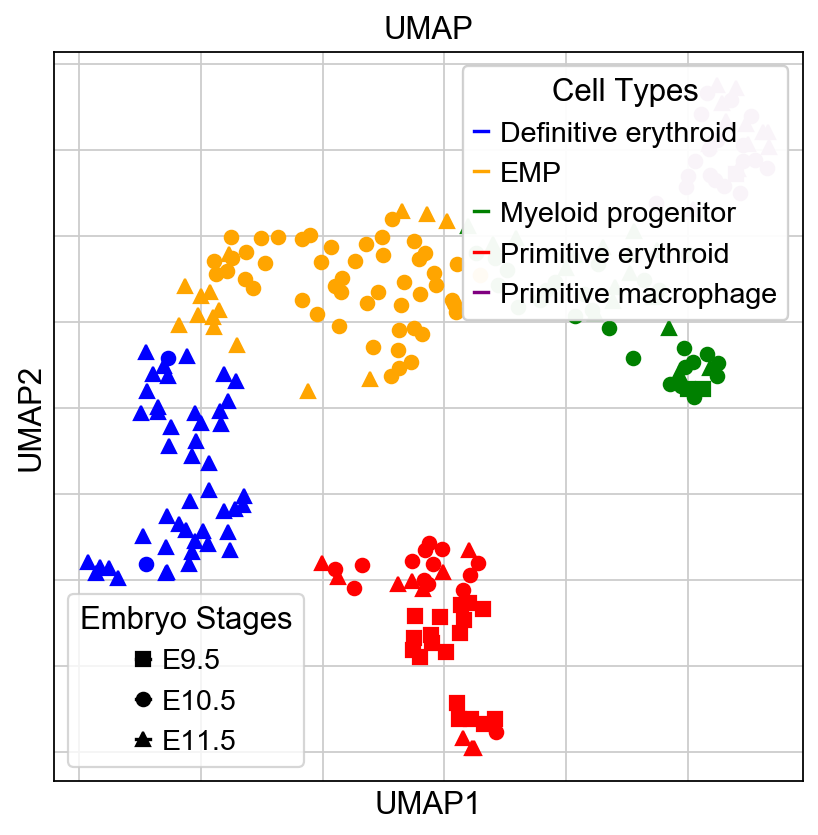

In [55]:
list_marker = ['s', 'o', '^']

legend_elements = [Line2D([0], [0], marker = 's', label = 'E9.5', color = 'black'),
                  Line2D([0], [0], marker = 'o', label = 'E10.5', color = 'black'),
                  Line2D([0], [0], marker = '^', label = 'E11.5', color = 'black')]
legend_el2 = [Line2D([0], [0], color = 'blue', label = 'Definitive erythroid'),
             Line2D([0], [0], color = 'orange', label = 'EMP'),
             Line2D([0], [0], color = 'green', label = 'Myeloid progenitor'),
             Line2D([0], [0], color = 'red', label = 'Primitive erythroid'),
             Line2D([0], [0], color = 'purple', label = 'Primitive macrophage')]

fig, ax = plt.subplots(figsize=(6,6))

for index, row in df.iterrows():
    color = ''
    marker = ''
    if row['Batch'] == 'E9.5':
        marker = 's'
    if row['Batch'] == 'E10.5':
        marker = 'o'
    if row['Batch'] == 'E11.5':
        marker = '^'
    if row['cell_type'] == 'Definitive erythroid':
        color = 'blue'
    if row['cell_type'] == 'EMP':
        color = 'orange'
    if row['cell_type'] == 'Myeloid progenitor':
        color = 'green'
    if row['cell_type'] == 'Primitive erythroid':
        color = 'red'
    if row['cell_type'] == 'Primitive macrophage':
        color = 'purple'
    ax.plot(row['x_umap'], row['y_umap'], marker = marker, color = color)
    

legend1 = plt.legend(handles = legend_elements, title = 'Embryo Stages', loc = 'bottom right')
legend2 = plt.legend(handles = legend_el2, title = 'Cell Types', loc = 'upper right')
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.title('UMAP')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False,top=False, labelleft=False)

plt.savefig('./datasets/epithelial_mesenchymal_transition/heme/figures/prettyplot1.pdf')

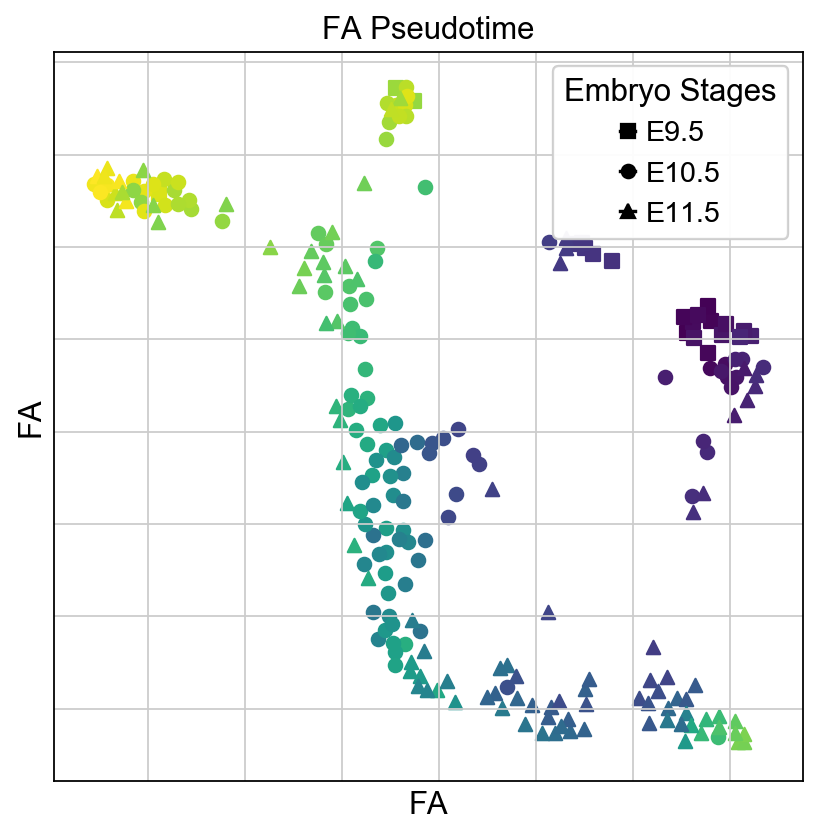

In [56]:
cmap = cm.get_cmap('viridis', len(df.index))
list_cols = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    list_cols.append(str(colors.rgb2hex(rgb)))
pts = list(df['pseudotime'])
pts.sort()

list_marker = ['s', 'o', '^']
list_color = ['blue', 'orange', 'green', 'red']

legend_elements = [Line2D([0], [0], marker = 's', label = 'E9.5', color = 'black'),
                  Line2D([0], [0], marker = 'o', label = 'E10.5', color = 'black'),
                  Line2D([0], [0], marker = '^', label = 'E11.5', color = 'black')]

fig, ax = plt.subplots(figsize=(6,6))


for index, row in df.iterrows():
    marker = ''
    if row['Batch'] == 'E9.5':
        marker = 's'
    if row['Batch'] == 'E10.5':
        marker = 'o'
    if row['Batch'] == 'E11.5':
        marker = '^'
    idx = pts.index(row['pseudotime'])
    plt.scatter(row['x_pst'], row['y_pst'], marker = marker, c=list_cols[idx])


    
legend1 = plt.legend(handles = legend_elements, title = 'Embryo Stages', loc = 'upper right')
ax.add_artist(legend1)
plt.title('FA Pseudotime')
plt.xlabel('FA')
plt.ylabel('FA')
plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False,top=False, labelleft=False)

plt.savefig('./datasets/epithelial_mesenchymal_transition/heme/figures/prettyplot2.pdf')